# Purpose

Explore the differences between the current geo-relevance definition compared to other approaches.

How many more subreddits do we gain by trying different definitions? Use some subreddits to check how geo-relevance definitions affect those subreddits.

2022-02-28:
- Pull from latest table (same as dashboard) -- it includes more countries
- Try a glocal tier score.  Instead of saying a subreddit is relevant because of any metric, create tiers based on the combination of geo+cultural metrics that make a subreddit qualify.

2022-02-14:
Use `djb_eda-01.x` to figure out thresholds (by checking ambassador subreddits & other subreddits that cover multiple countries). In this notebook, focus on what the outputs look like AFTER selecting the thresholds. 


In [1]:
%load_ext autoreload
%autoreload 2

# Register bigquery magic
%load_ext google.cloud.bigquery

# Imports

## General imports

In [2]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='notebook'

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted

# increase cell/notebook display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

## `subclu` imports (custom module)

In [3]:
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
    get_venn_sets2, get_venn_sets3
)
from subclu.utils.eda_geo_and_cultural_relevance import (
    show_geo_score_for_sub_single_table_new_metrics,
    show_geo_score_for_sub_single_table,
    show_geo_score_for_sub,
    display_top_subs_in_country,
    color_boolean,
    highlight_b, highlight_e
)


setup_logging()
notebook_display_config()  # e.g., increases default font size in matplotlib
print_lib_versions([pd, np, sns, plotly])

python		v 3.7.11
===
pandas		v: 1.2.4
numpy		v: 1.19.5
seaborn		v: 0.11.1
plotly		v: 4.14.3


# Define country list & some globals

In [4]:
l_i18n_target_countries = [
    'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
    'Mexico', 'Argentina', 'Chile',
    'Canada', 'United Kingdom', 'Australia',
]

# Pull data from BigQuery

## Language per subreddit

rank & % of posts per language, by subreddit

In [5]:
%%time
%%bigquery df_lang_by_subreddit --project data-science-prod-218515

-- Select only subreddits that have target language as primary or 2ndary language
WITH
    subreddits_with_target_languages AS (
        SELECT
            DISTINCT(subreddit_id) as subreddit_id
        FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` as geo
        WHERE
            subreddit_name IN (
                'formula1', 'rugbyunion', 'rugbyaustralia',
                'europe'
            )
            OR (
                (
                    language_rank = 1
                    OR language_rank = 2
                )
                AND language_name IN (
                    -- exclude English for now b/c it's most subreddits
                    -- 'English', 
                    'German', 
                    'French', 'Italian',
                    'Spanish', 'Portuguese',

                    -- Languages in India
                    'Hindi',
                    'Marathi',
                    'Tamil',
                    'Telugu',
                    'Malayalam'
                )
            )
    )


SELECT geo.*
FROM subreddits_with_target_languages sel
    LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` AS geo
        ON sel.subreddit_id = geo.subreddit_id

WHERE
    language_rank <= 3
ORDER BY subreddit_name ASC, language_rank ASC
;

Downloading: 100%|██████████████████████████████████████████████████████| 51633/51633 [00:01<00:00, 39002.12rows/s]

CPU times: user 137 ms, sys: 72.2 ms, total: 209 ms
Wall time: 3.34 s


In [6]:
print(df_lang_by_subreddit.shape)
df_lang_by_subreddit.head(7)

(51633, 14)


,rating_short,rating_name,primary_topic,subreddit_id,subreddit_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,None,None,None,t5_3cakx7,00fluffnstuff,en,post,41,23,0.560976,1,English,English,True
1,None,None,None,t5_3cakx7,00fluffnstuff,de,post,41,5,0.121951,2,German,German,True
2,None,None,None,t5_3cakx7,00fluffnstuff,lb,post,41,3,0.073171,3,Luxembourgish,Other_language,False
3,None,None,None,t5_4byrct,0nlyfantastic0,pt,post,13,7,0.538462,1,Portuguese,Portuguese,True
4,None,None,None,t5_4byrct,0nlyfantastic0,en,post,13,2,0.153846,2,English,English,True
5,None,None,None,t5_4byrct,0nlyfantastic0,es,post,13,1,0.076923,3,Spanish,Spanish,True
6,E,Everyone,Crypto,t5_5mmp3x,1000xcryptogems,en,post,34,33,0.970588,1,English,English,True


## Ambassador subreddits

In [7]:
%%time
%%bigquery df_ambassador_subs --project data-science-prod-218515

SELECT
    c.users_l7
    , posts_not_removed_l28
    , amb.*
FROM `reddit-employee-datasets.david_bermejo.ambassador_subreddits_union_20211216` AS amb
LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122` c
    ON amb.subreddit_id = c.subreddit_id
    
WHERE amb.subreddit_id IS NOT NULL

ORDER BY 1 DESC, 2 DESC

Downloading: 100%|████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 162.02rows/s]

CPU times: user 49.3 ms, sys: 13.3 ms, total: 62.6 ms
Wall time: 1.96 s


In [8]:
print(df_ambassador_subs.shape)
df_ambassador_subs.head(9)

(211, 11)


,users_l7,posts_not_removed_l28,subreddit_id,subreddit_name,i18n_topic,i18n_type,i18n_country_code,i18n_owner,i18n_type_2,ambassador_or_default_sub_germany,ambassador_or_default_sub_france
0,569489.0,2328.0,t5_22i0,de,None,organic,DE,None,None,True,False
1,494186.0,6067.0,t5_37k29,ich_iel,None,organic,DE,None,None,True,False
2,303499.0,4441.0,t5_2qhjz,askfrance,None,ambassador,FR,None,community builders,False,True
3,152153.0,2663.0,t5_2r6ca,fragreddit,None,organic,DE,None,inactive,True,False
4,118382.0,700.0,t5_3ntp6,wasletztepreis,None,organic,DE,None,None,True,False
5,102322.0,576.0,t5_33hvw,beziehungen,Dating & Relationship,ambassador,DE,None,None,True,False
6,64604.0,1113.0,t5_2yjbi,minecraftfr,None,ambassador,FR,None,community builders,False,True
7,62318.0,62.0,t5_30305,de_iama,None,organic,DE,None,None,True,False
8,52236.0,84.0,t5_3jxvk,tja,Fun,ambassador,DE,None,None,True,False


## Get top countries by Weekly active users 
NOTE that these might be not unique user counts.

In [9]:
%%time
%%bigquery df_top_countries --project data-science-prod-218515 

DECLARE regex_cleanup_country_name_str STRING DEFAULT r" of Great Britain and Northern Ireland| of America|";

WITH
  base as (
    SELECT
      date(pt) as dt
      , app_name
      , CASE
          when country is null then 'NULL'
          when country = 'all' then 'All'
          when country IN ('US','GB','CA','AU','DE','FR','IT','ES','IN','BR','MX','RO','NL') then country
          else 'ROW'
        END as country_code_group
      , COALESCE(country, "NULL") AS country_code
      , CASE 
          when country IN ('GB','AU','CA') then 'tier_0'
          when country IN ('DE','FR','BR','MX','IN') then 'tier_1'
          when country IN ('IT','ES','JP','KR','PH','NL','TR','RO','DK','SE','FI','PL','ID','RU') then 'tier_2'
          when country IN ('US') then 'US'
          else 'ROW'
        END as country_tier
      
      -- Split to remove long official names like:
      --   Tanzania, United Republic of; Bolivia, Plurinational State of
      , CASE
          WHEN country IS NULL THEN 'NULL'
          ELSE REGEXP_REPLACE(
            SPLIT(cm.country_name, ', ')[OFFSET(0)],
            regex_cleanup_country_name_str, ""
          )
          END AS country_name
      , cm.region AS geo_region
      
      , sum(users) as DAU

    from `data-prod-165221.metrics_fact_tables.dau_app_geo_reporting` AS g
      LEFT JOIN `data-prod-165221.ds_utility_tables.countrycode_region_mapping` AS cm
        ON g.country = cm.country_code

    WHERE 
      date(pt) >= date_sub(current_date(), interval 1 week)
      and app_name not in (
        'ads_platform',
        'guest1'
      )
    GROUP BY 1,2,3,4, 5, 6, 7
  ),
  week_agg AS (
    SELECT
      country_code
      , country_name
      , country_tier
      , geo_region

      , MAX(dt) date_pulled
      , DATE_DIFF(MAX(dt), MIN(dt), DAY) AS prev_days_counted
      , SUM(DAU) AS active_users
    FROM
      base
    GROUP BY 1, 2, 3, 4
  )


select
    *
from week_agg
ORDER BY active_users DESC
LIMIT 50
;

Downloading: 100%|███████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.71rows/s]

CPU times: user 77.3 ms, sys: 14.2 ms, total: 91.6 ms
Wall time: 3.61 s


In [10]:
print(df_top_countries.shape)
df_top_countries.head()

(50, 7)


,country_code,country_name,country_tier,geo_region,date_pulled,prev_days_counted,active_users
0,US,United States,US,NA,2022-03-01,6,457527722
1,GB,United Kingdom,tier_0,EMEA,2022-03-01,6,68069152
2,CA,Canada,tier_0,NA,2022-03-01,6,64405261
3,DE,Germany,tier_1,EMEA,2022-03-01,6,38418891
4,AU,Australia,tier_0,APAC,2022-03-01,6,32954451


## Default  geo-relevance score AND new scores

This table already has all the data pre-computed so let's simplify our lives with it

### SQL

In [327]:
%%time
%%bigquery df_geo_new --project data-science-prod-218515 

-- Get BOTH: old geo-relevance AND new geo-relevance (cultural relevance)
--  And add latest rating & over_18 flags to get best estimate of SFW subs for clustering

-- Set minimum thresholds for scores: b & e
--  These thresholds are lower than the final definition, but use them to check what it would take
--  to make some subs relevant to some countries
DECLARE B_MIN_USERS_PCT_BY_SUB DEFAULT 0.10;
DECLARE E_MIN_USERS_PCT_BY_COUNTRY_STANDARDIZED DEFAULT 0.7;
DECLARE TOP_N_RANK_SUBS_PER_COUNTRY DEFAULT 10;  -- include top subs even if they don't qualify under a relevance metric

WITH 
  relevance_default_tier_2 AS (
    -- we need an additional query to get tier 2 countries b/c they weren't included in the original
    -- default geo-relevance query
    SELECT
        subreddit_id
        , subreddit_name
        , geo_country_code
        , country_name
        , geo_relevance_default
    
    FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_default_daily_20220222`
    WHERE 1=1   
        AND geo_country_code IN (
            'JP','KR','PH','NL','TR','RO','DK','SE','FI','PL','ID','RU'
        )
  ),
  relevance_merge_t1_and_t2 AS (
    -- Add geo-relevant subs for tier 2 countries in a single table to make additional joins easier
    SELECT
        COALESCE(s.subreddit_id, t2.subreddit_id) AS subreddit_id
        , COALESCE(s.geo_country_code, t2.geo_country_code) AS geo_country_code
        , COALESCE(s.subreddit_name, t2.subreddit_name) AS subreddit_name
        , COALESCE(s.country_name, t2.country_name) AS country_name
        , CASE
            -- if it's a country in the t2 list, coalesce with t2 list first
            WHEN
                t2.geo_country_code IN (
                    'JP','KR','PH','NL','TR','RO','DK','SE','FI','PL','ID','RU'
                )
                THEN COALESCE(t2.geo_relevance_default, s.geo_relevance_default)
            -- for everything else, pick t1 value first
            ELSE COALESCE(s.geo_relevance_default, t2.geo_relevance_default)
            END
            AS geo_relevance_default

        , s.* EXCEPT(subreddit_id,  subreddit_name, country_name, geo_relevance_default, geo_country_code)
        
    FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_standardized_20220212` AS s
        -- Add geo-relevant subs for tier 2 countries
        FULL OUTER JOIN relevance_default_tier_2 AS t2
          ON s.subreddit_id = t2.subreddit_id AND s.geo_country_code = t2.geo_country_code
  ),
  relevance_base AS (
    SELECT
        nt.rating_name
        , nt.primary_topic
        , nt.rating_short
        , slo.over_18
        , CASE 
            WHEN(COALESCE(slo.over_18, 'f') = 't') THEN 'X_or_over_18'
            WHEN(COALESCE(nt.rating_short, '') IN ('X')) THEN 'X_or_over_18'
            ELSE 'unrated_or_E_M_D_V'
        END AS grouped_rating
        , CASE 
            WHEN(COALESCE(tm.subreddit_id, '') != '') THEN 'subreddit_in_model'
            ELSE 'subreddit_missing'
        END AS subreddit_in_v041_model
        , s.* EXCEPT(over_18, pt, verdict, users_percent_by_country_stdev, type) 
    
    FROM relevance_merge_t1_and_t2 AS s
        -- Add rating so we can get an estimate for how many we can actually use for recommendation
        LEFT JOIN (
            SELECT *
            FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
            WHERE dt = DATE(CURRENT_DATE() - 2)
        ) AS slo
        ON s.subreddit_id = slo.subreddit_id
        LEFT JOIN (
            SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
            WHERE pt = (CURRENT_DATE() - 2)
        ) AS nt
            ON s.subreddit_id = nt.subreddit_id
    
        -- Exclude popular US subreddits
        -- Can't query this table from local notebook because of errors getting google drive permissions. smh, excludefor now
        -- LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddits_top_us_to_exclude_from_relevance` tus
        --     ON s.subreddit_name = LOWER(tus.subreddit_name)
    
        -- Add latest table for v0.4.1 model so we can count which ones are missing
        LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_v0041_subreddit_clusters_c_a` tm
            ON s.subreddit_id = tm.subreddit_id
    
    WHERE 1=1
        AND s.subreddit_name != 'profile'
        AND COALESCE(slo.type, '') = 'public'
        AND COALESCE(slo.verdict, 'f') <> 'admin_removed'

    ), 
    subs_and_countries_above_thresh AS (
        -- Select only country+subs that make the cut by threshold AND target countries
        SELECT *
        FROM relevance_base
        WHERE 1=1
          AND (
              geo_relevance_default = TRUE
              OR b_users_percent_by_subreddit >= B_MIN_USERS_PCT_BY_SUB
              OR e_users_percent_by_country_standardized >= E_MIN_USERS_PCT_BY_COUNTRY_STANDARDIZED
          )
          AND (
              -- tier 0
              geo_country_code IN ('GB','AU','CA')
              
              -- tier 1
              OR geo_country_code IN ('DE','FR','BR','MX','IN')
              
              -- tier 2
              OR geo_country_code IN ('IT','ES','JP','KR','PH','NL','TR','RO','DK','SE','FI','PL','ID','RU')
              
              -- Additional countries, PT=Portugal, AR=Argentina
              OR country_name IN (
                    'Portugal', 'Argentina', 'Austria'
              )
          )
    ),
    subs_broad_relevance AS (
        -- Select subreddits that we expect to be widely relevant, even if not in a target country
        --   These can help us adjust thresholds or understand why a country doesn't qualify
            SELECT *
            FROM relevance_base
            WHERE 1=1
              AND (
                  geo_relevance_default = TRUE
                  OR b_users_percent_by_subreddit >= 0.008 -- countries with more than 1% of visits
                  OR e_users_percent_by_country_standardized >= 0.01  -- Pull countries slightly above average
              )
              AND subreddit_name IN (
                  'cricket', 
                  'soccer', 'futbol', 'football', 'fussball',
                  'formula1',
                  'rugbyunion',
                  'premierleague',
                  'rugbyaustralia',
                  'bundesliga',
                  'reddevils',
                  'liverpoolfc',
                  'ligue1',
                  'laliga',
                  'barca',
                  'ligamx',
                  'seriea',
                  'rappers', 'germanrap', 
                  'antiwork', 'wallstreetbets',
                  'utahjazz',
                  'ich_iel', 'de', 'rance', 'rance_iel', 'ipl'
              )
    ),
    top_subs_in_target_countries AS (
        -- Select country+subs that are the top ranked in target countries, even if not relevant
        SELECT *
        FROM relevance_base
        WHERE 1=1
            AND (d_users_percent_by_country_rank <= TOP_N_RANK_SUBS_PER_COUNTRY)
            AND country_name IN (
                    'Germany', 'Austria', 'India', 'France', 'Brazil','Italy',
                    'Spain', 'Mexico', 
                    -- 'Argentina', 'Portugal',
                    'United Kingdom', 'Canada', 'Australia'
                  )
        
            -- AND (
            --     -- Exclude subs that are top in US but we want to exclude as culturally relevant
            --     --  For simplicity, let's go with the English exclusion (more relaxed) than the non-English one
            --     COALESCE(tus.english_exclude_from_relevance, '') <> 'exclude'
            -- )
    )


SELECT 
    DISTINCT *
FROM ( 
    SELECT * FROM subs_and_countries_above_thresh
    UNION ALL
    SELECT * FROM subs_broad_relevance
    UNION ALL
    SELECT * FROM top_subs_in_target_countries
)

ORDER BY users_l7 DESC, subreddit_name, c_users_percent_by_country DESC


Downloading: 100%|███████████████████████████████████████████████████| 221048/221048 [00:01<00:00, 130625.05rows/s]

CPU times: user 762 ms, sys: 274 ms, total: 1.04 s
Wall time: 22.1 s


### Checks & assign names

In [328]:
print(df_geo_new.shape)
df_geo_new.head(7)

(221048, 24)


,rating_name,primary_topic,rating_short,over_18,grouped_rating,subreddit_in_v041_model,subreddit_id,geo_country_code,subreddit_name,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg
0,Everyone,Learning and Education,E,f,unrated_or_E_M_D_V,subreddit_in_model,t5_2qh1i,CA,askreddit,Canada,False,0.082103,2.063704,0.058489,1.0,False,True,2427411.0,41502030.0,29565392.0,229399.0,12688040.0,119.0,0.03238
1,Everyone,Learning and Education,E,f,unrated_or_E_M_D_V,subreddit_in_model,t5_2qh1i,AU,askreddit,Australia,False,0.041263,1.898226,0.056395,1.0,False,False,1219952.0,21632112.0,29565392.0,229399.0,12688040.0,119.0,0.03238
2,Everyone,Learning and Education,E,f,unrated_or_E_M_D_V,subreddit_in_model,t5_2qh1i,GB,askreddit,United Kingdom,False,0.080184,1.719594,0.054135,1.0,False,False,2370685.0,43791735.0,29565392.0,229399.0,12688040.0,119.0,0.03238
3,Everyone,Learning and Education,E,f,unrated_or_E_M_D_V,subreddit_in_model,t5_2qh1i,DK,askreddit,Denmark,False,0.005026,1.280126,0.048576,2.0,False,False,148592.0,3058990.0,29565392.0,229399.0,12688040.0,119.0,0.03238
4,Everyone,Learning and Education,E,f,unrated_or_E_M_D_V,subreddit_in_model,t5_2qh1i,SE,askreddit,Sweden,False,0.009952,1.190272,0.047439,2.0,False,False,294226.0,6202233.0,29565392.0,229399.0,12688040.0,119.0,0.03238
5,Everyone,Learning and Education,E,f,unrated_or_E_M_D_V,subreddit_in_model,t5_2qh1i,FI,askreddit,Finland,False,0.005523,0.957982,0.044500,2.0,False,False,163302.0,3669717.0,29565392.0,229399.0,12688040.0,119.0,0.03238
6,Everyone,Learning and Education,E,f,unrated_or_E_M_D_V,subreddit_in_model,t5_2qh1i,NL,askreddit,Netherlands,False,0.014163,0.904163,0.043819,1.0,False,False,418728.0,9555855.0,29565392.0,229399.0,12688040.0,119.0,0.03238


`34470, 26`

In [329]:
# fill some nulls that throw off data types:
df_geo_new['num_of_countries_with_visits_l28'] = df_geo_new['num_of_countries_with_visits_l28'].fillna(0).astype(int)

In [330]:
# df_geo_new_only_relevant = (
#     df_geo_new_raw
#     [
#         (df_geo_new_raw['geo_relevance_default'] == True) |
#         (df_geo_new_raw['relevance_percent_by_subreddit'] == True) |
#         (df_geo_new_raw['relevance_percent_by_country_standardized'] == True)
#     ]
# ).copy()
# print(df_geo_new_only_relevant.shape)

In [331]:
# df_geo_new.head(7)

In [332]:
counts_describe(
    df_geo_new.iloc[:, :12]
)

,dtype,count,unique,unique-percent,null-count,null-percent
rating_name,object,"194,641",5,0.00%,"26,407",11.95%
primary_topic,object,"182,464",52,0.03%,"38,584",17.46%
rating_short,object,"194,641",5,0.00%,"26,407",11.95%
over_18,object,"95,570",2,0.00%,"125,478",56.77%
grouped_rating,object,"221,048",2,0.00%,0,0.00%
subreddit_in_v041_model,object,"221,048",2,0.00%,0,0.00%
subreddit_id,object,"221,048","82,707",37.42%,0,0.00%
geo_country_code,object,"221,048",186,0.08%,0,0.00%
subreddit_name,object,"221,048","82,707",37.42%,0,0.00%
country_name,object,"221,048",185,0.08%,0,0.00%


### Checks for new metrics

In [333]:
style_df_numeric(
    df_geo_new
    [['b_users_percent_by_subreddit',
      # 'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=1,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
b_users_percent_by_subreddit,"221,048",7.5%,0.15,0.0%,0.6%,1.2%,3.1%,7.7%,8.8%,12.5%,28.2%,75.1%,84.9%,89.3%,94.5%,97.4%,100.0%


In [334]:
style_df_numeric(
    df_geo_new
    [[
      'e_users_percent_by_country_standardized',
    ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
e_users_percent_by_country_standardized,"221,048",1.52,1.09,-1.58,0.74,0.89,1.23,1.80,2.00,2.65,3.49,4.95,6.10,7.21,9.48,10.62,10.80


In [335]:
style_df_numeric(
    df_geo_new
    [[
      'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=3,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
c_users_percent_by_country,"221,048",0.025%,0.00,0.000%,0.000%,0.001%,0.003%,0.011%,0.015%,0.038%,0.086%,0.217%,0.455%,0.762%,1.833%,4.433%,15.318%


In [336]:
# ax = sns.boxenplot(
#     x=df_geo_new
#     .drop_duplicates(subset=['country_name'])
#     ['total_users_in_country_l28'].fillna(0)
# )

In [337]:
# ax = sns.boxenplot(
#     x=(
#         df_geo_new
#         [df_geo_new['total_users_in_country_l28'] <= 1e7]
#         .drop_duplicates(subset=['country_name'])
#         ['total_users_in_country_l28'].fillna(0)
#     )
# )

### What are ~MAU for i18n target countries?

In [338]:
style_df_numeric(
    df_geo_new
    .drop_duplicates(subset=['country_name'])
    [['total_users_in_country_l28',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,max
total_users_in_country_l28,185,"3,684,000.86","22,434,385.68","5,012.00","11,214.40","29,588.00","234,200.00","1,387,904.00","2,260,341.20","3,958,650.40","11,277,279.80","296,900,804.00"


In [339]:
style_df_numeric(
    df_geo_new
    [df_geo_new['country_name'].isin(['United States'] + l_i18n_target_countries)]
    .drop_duplicates(subset=['country_name'])
    [['country_name', 'total_users_in_country_l28']]
    .sort_values(by=['total_users_in_country_l28'], ascending=False)
    .reset_index(drop=True)
)

,country_name,total_users_in_country_l28
0,United States,"296,900,804"
1,United Kingdom,"43,791,735"
2,Canada,"41,502,030"
3,Germany,"24,269,505"
4,Australia,"21,632,112"
5,India,"18,260,996"
6,Brazil,"16,717,071"
7,France,"10,828,979"
8,Mexico,"9,560,631"
9,Italy,"7,129,646"


In [340]:
# fig = px.box(
#     x=(
#         df_geo_new
#         [df_geo_new['total_users_in_country_l28'] <= 1e10]
#         .drop_duplicates(subset=['country_name'])
#         ['total_users_in_country_l28'].fillna(0)
#     )
# )
# fig.show()

# Create masks for most common cases
Reuse these to get consistent numbers & avoid re-calculating errors (& wasted time)

In [341]:
# cols referenced often
col_geo_relevant_output = 'geo_relevance_default'

# masks
mask_x_or_over_18 = df_geo_new['grouped_rating'] == 'X_or_over_18'

mask_default_relevance_only = (
  (df_geo_new['geo_relevance_default'] == True)
)
print(f"{mask_default_relevance_only.sum():,.0f} <- count relevant subs only DEFAULT")

mask_relevance_by_at_least_one_metric = (
  (df_geo_new['geo_relevance_default'] == True) |
  (df_geo_new['relevance_percent_by_subreddit'] == True) |
  (df_geo_new['relevance_percent_by_country_standardized'] == True)
)
print(f"{mask_relevance_by_at_least_one_metric.sum():,.0f} <- count relevant subs all metrics")

# use this mask to show why straight rank isn't as helpful
#  because a lot of these subs are popular all over the world and there's
#  no need for us to highlight/promote them as relevant (they tend to be in English)
n_top_subs_per_country_ = 10
mask_top_n_or_relevant = (
  mask_relevance_by_at_least_one_metric |
  (df_geo_new['d_users_percent_by_country_rank'] <= n_top_subs_per_country_)
)
print(f"{mask_top_n_or_relevant.sum():,.0f} <- count subs relevant OR in top N: {n_top_subs_per_country_}")

# get only subs that belong to top countries
mask_top_n_countries_ = (
  df_geo_new['geo_country_code'].isin(df_top_countries['country_code'].unique())
)
print(f"{mask_top_n_countries_.sum():,.0f} <- count subs that belong to top countries")

l_t0_and_t1_countries_ = [
  'GB','AU','CA',
  'DE','FR','BR','MX','IN',
]
l_t2_countries_ = [
  'IT','ES', 'JP','KR','PH','NL','TR','RO','DK','SE','FI','PL','ID','RU'
]
mask_subs_for_countries_t0_to_t2_ = (
  df_geo_new['geo_country_code'].isin(l_t0_and_t1_countries_ + l_t2_countries_)
)
print(f"{mask_subs_for_countries_t0_to_t2_.sum():,.0f} <- count subs that belong to tier0 to tier2 countries")

mask_subreddits_in_v041_model = (
  df_geo_new['subreddit_in_v041_model'] == 'subreddit_in_model'
)
print(f"{mask_subreddits_in_v041_model.sum():,.0f} <- count subs+country pairs in v0.4.1 model")

12,065 <- count relevant subs only DEFAULT
53,359 <- count relevant subs all metrics
53,494 <- count subs relevant OR in top N: 10
220,279 <- count subs that belong to top countries
198,490 <- count subs that belong to tier0 to tier2 countries
125,331 <- count subs+country pairs in v0.4.1 model


# Get counts for top tier countries

In [416]:
col_old_metric_subs_raw_ = 'old_metric'
col_new_metrics_subs_raw_ = 'z_new_metric'
col_total_subs_ = 'subreddit_count_total'
col_sub_pct_increase = 'percent_increase_over_previous_score'
d_rename_country_count_cols_for_display = {
  col_old_metric_subs_raw_: 'subreddit count<br>old metric',
  col_new_metrics_subs_raw_: 'subreddit count<br>new metrics',
  col_total_subs_: 'subreddit count<br>total',
  col_sub_pct_increase: 'percent_increase<br>over old score',
}


df_geo_counts_per_country = (
  value_counts_and_pcts(
      df_geo_new
      [
        ~mask_x_or_over_18 & 
        mask_relevance_by_at_least_one_metric &
        mask_subs_for_countries_t0_to_t2_
      ]
      .replace(
        {'geo_relevance_default': 
          {
            False: col_new_metrics_subs_raw_,
            True: col_old_metric_subs_raw_,
          },
        }
      )
      # merge to get the county tier
      .merge(
        df_top_countries[['country_code', 'country_tier']]
        .rename(columns={'country_code': 'geo_country_code'}),
        how='left',
        on=['geo_country_code'],
      )
      ,
      ['country_name', 'country_tier', col_geo_relevant_output],
      sort_index=True,
      cumsum=False,
      top_n=None,
      count_type='subreddits',
      # reset_index=True,
      return_df=True
  )
  .drop('percent_of_subreddits', axis=1)
  .unstack()
  .droplevel(0, axis=1)
  .reset_index()
  
  # create a col for total subreddits
  # create a col for % additional subs
  .assign(
    **{
      col_total_subs_: lambda x: x[col_old_metric_subs_raw_] + x[col_new_metrics_subs_raw_],
      col_sub_pct_increase: lambda x: x[col_new_metrics_subs_raw_] / x[col_old_metric_subs_raw_],
    }
  )
)

style_df_numeric(
  # unstack so we get the value as a column
  df_geo_counts_per_country
  .sort_values(by=[col_total_subs_], ascending=False)
  .rename(columns=d_rename_country_count_cols_for_display),
  rename_cols_for_display=True,
  pct_digits=1,
  l_bar_simple=[
    d_rename_country_count_cols_for_display[col_total_subs_],
  ]
).hide_index().set_caption(
  '<h4 align="left">Geo+culturally relevant counts</h4>'
  f'<div align="left">Excluding `over_18` and `X-rated` subreddits</div>'
)

country name,country tier,subreddit countold metric,subreddit countnew metrics,subreddit counttotal,percent increaseover old score
United Kingdom,tier_0,"1,343","3,731","5,074",277.8%
Canada,tier_0,996,"3,161","4,157",317.4%
Russian Federation,tier_2,"1,098","2,795","3,893",254.6%
Denmark,tier_2,71,"2,038","2,109","2,870.4%"
Finland,tier_2,80,"2,013","2,093","2,516.2%"
India,tier_1,720,"1,298","2,018",180.3%
Australia,tier_0,391,"1,420","1,811",363.2%
Philippines,tier_2,274,"1,510","1,784",551.1%
Germany,tier_1,866,873,"1,739",100.8%
Sweden,tier_2,173,"1,368","1,541",790.8%


# Define focused cols to display in tables

In [417]:
col_e_scaled_new_rel = 'e_standardized_for_new_score'
col_new_relevance_score = 'relevance_combined_score'
col_new_rel_score_tier = 'relevance_glocal_tier'


col_glocal_tier = 'glocal_tier'
col_glocal_tier_name = 'glocal_tier_name'


l_cols_base_merge = [
    # 'subreddit_id',
    'subreddit_name',
    'country_name',
]

col_a = 'geo_relevance_default'
col_a_display = col_a.replace('_', ' ')

col_b_users_pct_sub = 'b_users_percent_by_subreddit'
col_b_display = 'b users percent by subreddit'
col_b = col_b_display.replace(' ', '_')

col_e_display = 'e users percent by country standardized'
col_e = col_e_display.replace(' ', '_')

col_b_bool = 'relevance_percent_by_subreddit'
col_b_bool_disp = col_b_bool.replace('_', ' ')
col_e_bool = 'relevance_percent_by_country_standardized'
col_e_bool_disp = col_e_bool.replace('_', ' ')

l_cols_new_pcts_extra = l_cols_base_merge + [
    col_new_rel_score_tier,
    col_new_relevance_score,
    col_b,
    col_e,
    col_a,
    col_b_bool,
    col_e_bool,

    'users_in_subreddit_from_country_l28',
    'num_of_countries_with_visits_l28',

    'd_users_percent_by_country_rank',
    col_e_scaled_new_rel,
    'c_users_percent_by_country',

    # col_glocal_tier_name,
    col_glocal_tier,
    'users_percent_by_country_avg',

    # 'total_users_in_subreddit_l28',
    'total_users_in_country_l28',
]
l_cols_lang_disp_check = [
    'subreddit_name'
    'language_name',
    'language_percent',
    'language_rank',
    'language_count',
    'weighted_language',
]

l_cols_lang_single = [c for c in l_cols_lang_disp_check if c != 'subreddit_id']

# Create new combined score to get a combined number for easier interpretation & creation of tiers

We want to 
- use (B) % of subreddit in L28 as the core
- Add some weight from the standardized score (E) to (B)
    - cap the maximum contribution from E

So the score should range from 0 to 1.25 (might display it as 125% for now) but could go back and normalize it later

In [418]:
const_multiply_e = 0.25 / np.log(11)
const_multiply_e

0.10425809785606158

In [419]:
for e_score_ in [0, 0.1, 0.5, 1, 1.5, 1.75, 2, 4, 5, 8, 10]:
    print(f"E: {e_score_:4,.1f} -> {const_multiply_e * np.log(1 + e_score_):6,.2%}")

E:  0.0 ->  0.00%
E:  0.1 ->  0.99%
E:  0.5 ->  4.23%
E:  1.0 ->  7.23%
E:  1.5 ->  9.55%
E:  1.8 -> 10.55%
E:  2.0 -> 11.45%
E:  4.0 -> 16.78%
E:  5.0 -> 18.68%
E:  8.0 -> 22.91%
E: 10.0 -> 25.00%


In [420]:
# create new scaled relevance column
mask_e_below_0 = df_geo_new[col_e].fillna(0) <= 0
s_log_e_ = const_multiply_e * np.log(
    1 + np.where(
        mask_e_below_0,
        0,
        df_geo_new[col_e],
    )
)
df_geo_new[col_e_scaled_new_rel] = np.where(
    mask_e_below_0,
    0,
    np.fmin([0.25] * len(df_geo_new), s_log_e_)
)
# print(df_geo_new[col_e_scaled_new_rel].describe())

# create new combined score
df_geo_new[col_new_relevance_score] = (
    df_geo_new[col_b].fillna(-1) +
    df_geo_new[col_e_scaled_new_rel]
)

# check new score to create tiers
# print(df_geo_new[col_e_scaled_new_rel].describe())

## Create tiers based on new score
Use the tiers from the binary scores as input to create these new tiers.

Spiros mentioned that he'd prefer 3 tiers instead of 6, so let's try it to roll things up.

- If we want 3 tiers, here's what we want:
    - New 1:
        - Old: 1 and 2
        - Minimum cut off: >= 80
    - New 2:
        - Old: 3 and 5
        - Minimum cut off: >= 30
    - New 3:
        - Old: 4 and 6
        - Minimum cut off: (below 30)

In [421]:
df_geo_new[col_new_rel_score_tier] = (
    pd.cut(
        df_geo_new[col_new_relevance_score],
        bins=[-5, -0.01, 0.2, 0.32, 0.6, 1.9],
        labels=[-1, 4, 3, 2, 1]
    )
).astype(int)
display(value_counts_and_pcts(df_geo_new[col_new_rel_score_tier], sort_index=True,))
display(
    value_counts_and_pcts(
        df_geo_new[mask_relevance_by_at_least_one_metric][col_new_rel_score_tier],
        sort_index=True,
    )
)

,relevance_glocal_tier-count,relevance_glocal_tier-percent,relevance_glocal_tier-pct_cumulative_sum
-1,958,0.4%,0.4%
1,"8,802",4.0%,4.4%
2,"4,864",2.2%,6.6%
3,"19,212",8.7%,15.3%
4,"187,212",84.7%,100.0%


,relevance_glocal_tier-count,relevance_glocal_tier-percent,relevance_glocal_tier-pct_cumulative_sum
-1,958,1.8%,1.8%
1,"8,802",16.5%,18.3%
2,"4,864",9.1%,27.4%
3,"15,418",28.9%,56.3%
4,"23,317",43.7%,100.0%


## Create new df with only relevant countries

Makes it easier to have one fewer mask 

In [422]:
mask_target_countries = df_geo_new['country_name'].isin(l_i18n_target_countries)
df_geo_new_only_relevant = df_geo_new[mask_target_countries & mask_relevance_by_at_least_one_metric].copy()

print(df_geo_new_only_relevant.shape)

(31856, 27)


In [423]:
value_counts_and_pcts(
    df_geo_new_only_relevant[col_new_rel_score_tier],
    sort_index=True,
)

,relevance_glocal_tier-count,relevance_glocal_tier-percent,relevance_glocal_tier-pct_cumulative_sum
1,"7,399",23.2%,23.2%
2,"3,794",11.9%,35.1%
3,"11,183",35.1%,70.2%
4,"9,480",29.8%,100.0%


## Check distribution of new metric only on relevant country+sub pairs
This way we reduce the skew from other smaller countries

In [424]:
style_df_numeric(
    df_geo_new_only_relevant
    [[col_e_scaled_new_rel,
      col_b,
      col_new_relevance_score,
     ]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
        percentiles=[.1, .25, .4, .5, .6, .75, .8, .85, .9, .95, .99]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=1,
).set_caption(f"Distribution for new metric. Subs relevant with 1+ metric | Only target i18n countries")

,count,mean,std,min,10%,25%,40%,50%,60%,75%,80%,85%,90%,95%,99%,max
e_standardized_for_new_score,"31,856",12.8%,0.05,0.0%,6.6%,11.6%,12.3%,12.9%,13.5%,15.1%,15.9%,16.9%,18.3%,20.3%,23.5%,25.0%
b_users_percent_by_subreddit,"31,856",26.1%,0.28,0.4%,3.0%,6.6%,9.7%,13.3%,17.0%,38.6%,55.4%,67.9%,77.6%,85.8%,93.0%,99.2%
relevance_combined_score,"31,856",38.9%,0.29,0.5%,15.2%,19.0%,22.0%,24.5%,28.4%,52.9%,70.8%,83.5%,92.5%,100.2%,109.6%,121.1%


In [425]:
style_df_numeric(
    df_geo_new[mask_relevance_by_at_least_one_metric]
    [[col_e_scaled_new_rel,
      col_b,
      col_new_relevance_score,
     ]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
        percentiles=[.1, .25, .4, .5, .6, .75, .8, .85, .9, .95, .99]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=1,
).set_caption(f"Distribution for new metric. Subs relevant with 1+ metric | All calculated countries")

,count,mean,std,min,10%,25%,40%,50%,60%,75%,80%,85%,90%,95%,99%,max
e_standardized_for_new_score,"53,359",12.8%,0.05,0.0%,7.4%,11.7%,12.4%,12.9%,13.6%,15.1%,15.8%,16.7%,18.1%,20.0%,23.3%,25.0%
b_users_percent_by_subreddit,"53,359",19.4%,0.26,0.0%,1.1%,2.5%,5.5%,8.1%,11.0%,20.4%,30.1%,52.1%,70.2%,83.1%,92.3%,100.0%
relevance_combined_score,"53,359",30.5%,0.32,-100.0%,13.4%,15.7%,18.7%,21.0%,23.7%,32.8%,43.7%,67.3%,85.9%,97.6%,108.4%,121.1%


Only selected i18n target countries


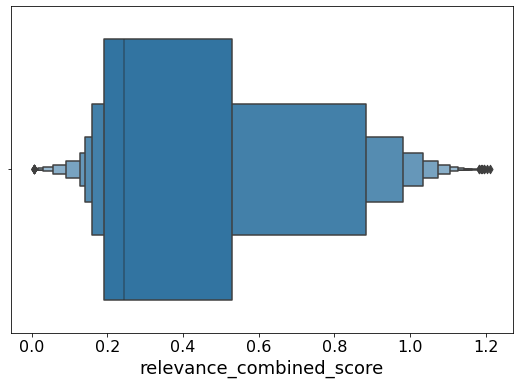

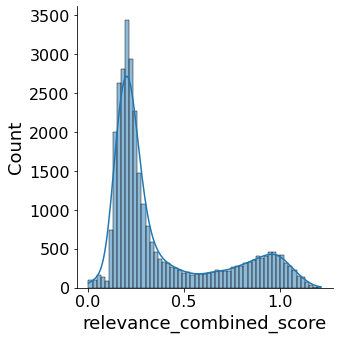

In [426]:
print(f"Only selected i18n target countries")
ax = sns.boxenplot(
    x=df_geo_new_only_relevant
    [col_new_relevance_score].fillna(0)
)
plt.show()
ax = sns.displot(
    x=df_geo_new_only_relevant
    [col_new_relevance_score].fillna(0),
    kde=True,
)
plt.show()

All countries


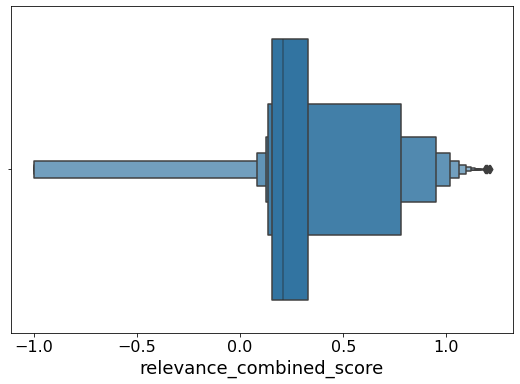

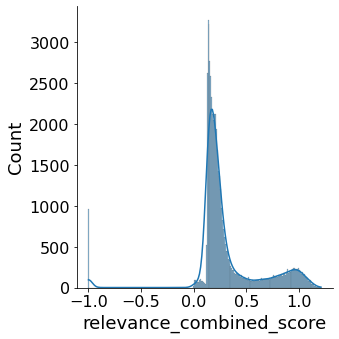

In [427]:
print(f"All countries")
ax = sns.boxenplot(
    x=df_geo_new[mask_relevance_by_at_least_one_metric]
    [col_new_relevance_score].fillna(0)
)
plt.show()
ax = sns.displot(
    x=df_geo_new[mask_relevance_by_at_least_one_metric]
    [col_new_relevance_score].fillna(0),
    kde=True,
)

# Compare A, B & E sets - They're complementary

how many more do we add by including C & E on top of A?

By combining C & E + A, we get an additional 38,288 "geo-cultural" pairs that the baseline metric (A) didn't cover.

These 3 metrics are also complementary -- we can see that each of them contributes over 2,000 pairs not covered by the others.

---
How many more do we get by adding the new thresholds?

- A. % by sub daily
- B. % by sub L28 days
- C. % by country L28 days
- D. Rank of C (country)
- E. Standard scale C (country)


NOTE: we need to compare subreddit+country PAIRS! because one sub could be relevant to multiple countries at different thresholds.


In [428]:
# Here we don't need to adjust thresholds, they've already been defined in the bigQuery table
# threshold_b_sub = 0.14
# threshold_e_country_standardized = 2.0

mask_a_default = (
    # mask_target_countries &
    (df_geo_new_only_relevant['geo_relevance_default'] == True)
)
print(f"A: {mask_a_default.sum():7,.0f}")

mask_thresh_b = (
    # mask_target_countries &
    (df_geo_new_only_relevant['relevance_percent_by_subreddit'] == True)
)
print(f"B: {mask_thresh_b.sum():7,.0f}")

mask_thresh_e = (
    # mask_target_countries &
    (df_geo_new_only_relevant['relevance_percent_by_country_standardized'] == True)
)
print(f"E: {mask_thresh_e.sum():7,.0f}")

A:   8,913
B:  15,611
E:  24,890


 8,913 <- A
15,611 <- B
24,890 <- E
---
31,856 <- A OR B OR E

16,661 <- A OR B
27,170 <- A OR E
30,929 <- B OR E


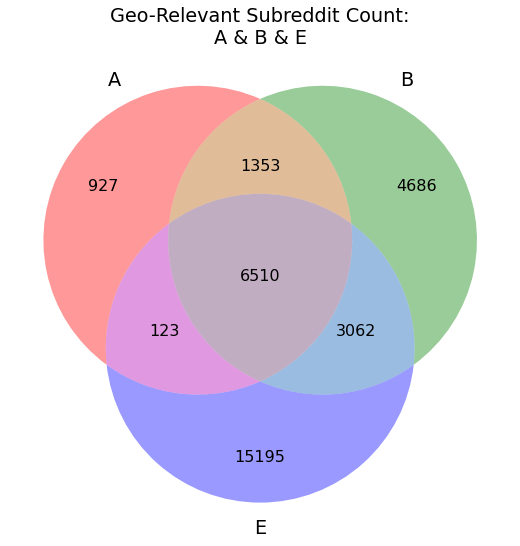

In [429]:
plt.figure(figsize=(10, 9))

lbls_ = ['A', 'B', 'E']

s_subs_a = (
    df_geo_new_only_relevant[mask_a_default]['subreddit_name'] + '-' +
    df_geo_new_only_relevant[mask_a_default]['country_name'] 
)
s_subs_b = (
    df_geo_new_only_relevant[mask_thresh_b]['subreddit_name'] + '-' +
    df_geo_new_only_relevant[mask_thresh_b]['country_name'] 
)
s_subs_e = (
    df_geo_new_only_relevant[mask_thresh_e]['subreddit_name'] + '-' +
    df_geo_new_only_relevant[mask_thresh_e]['country_name'] 
)

d_sets_abe = get_venn_sets3(
    s_subs_a, s_subs_b, s_subs_e, 
    *lbls_
)

ax = venn3_unweighted(
    [
        set(s_subs_a), 
        set(s_subs_b),
        set(s_subs_e),
    ],
    set_labels=lbls_,
)
plt.title(f"Geo-Relevant Subreddit Count:\n{' & '.join(lbls_)}");

# Define new `glocal` tiers

Having 3 separate columns can be confusing. We want a single column/value to make it easy to identify the level of "how local" a subreddit is.

We can create this score based on combining the 3 scores (A, B, E).

## Check distribution of B & E

In [430]:
style_df_numeric(
    df_geo_new_only_relevant
    [['b_users_percent_by_subreddit',
      # 'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .99]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=1,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,99%,max
b_users_percent_by_subreddit,"31,856",26.1%,0.28,0.4%,3.0%,6.6%,13.3%,38.6%,55.4%,77.6%,85.8%,93.0%,99.2%


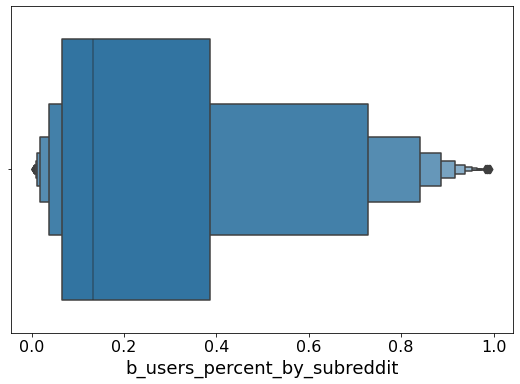

In [431]:
ax = sns.boxenplot(
    x=df_geo_new_only_relevant
    ['b_users_percent_by_subreddit'].fillna(0)
)

In [432]:
style_df_numeric(
    df_geo_new_only_relevant
    [[
      'e_users_percent_by_country_standardized',
    ]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .99]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,99%,max
e_users_percent_by_country_standardized,"31,856",2.73,1.65,-1.58,0.88,2.04,2.43,3.27,3.61,4.78,6.00,8.54,10.78


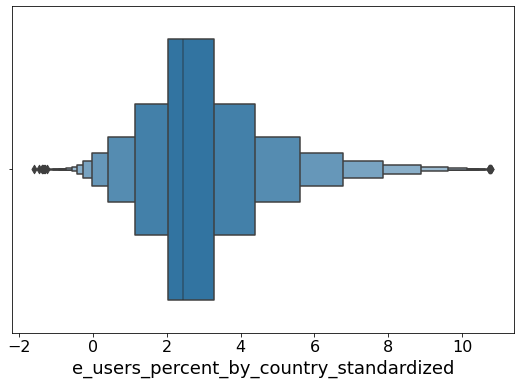

In [433]:
ax = sns.boxenplot(
    x=df_geo_new_only_relevant
    ['e_users_percent_by_country_standardized'].fillna(0)
)

## Define tiers (old method with masks)

In [434]:

df_geo_new_only_relevant[col_glocal_tier] = 9

# define in descending order so that we can over-ride higher value ones later
d_glocal_mask_tiers = {
    6: {
        'name': '6. Some local interest niche',
        'mask': (mask_thresh_e & ~mask_thresh_b & ~mask_a_default),
    },
    5: {
        'name': '5. Some local interest',
        'mask': (mask_thresh_b & ~mask_thresh_e & ~mask_a_default),
    },
    4: {
        'name': '4. Medium local for a short time',
        'mask': (
            (mask_a_default & ~mask_thresh_b & ~mask_thresh_e) |
            ((mask_a_default & mask_thresh_e) & ~mask_thresh_b)
        ),
    },
    3: {
        'name': '3. Medium local',
        'mask': (
            ((mask_thresh_b & mask_thresh_e) & ~mask_a_default) |
            (mask_a_default & mask_thresh_b & mask_thresh_e)
        ),
    },
    2: {
        'name': '2. Highly local steady',
        'mask': (
            ((mask_a_default & mask_thresh_b) & ~mask_thresh_e) |
            (df_geo_new_only_relevant[col_b_users_pct_sub] >= .50)
        ),
    },
    1: {
        'name': '1. Hyper local',
        'mask': (
            (mask_a_default & mask_thresh_b & mask_thresh_e) &
            (df_geo_new_only_relevant[col_b_users_pct_sub] >= .8)
        ),
    },
}
for val_, d_ in d_glocal_mask_tiers.items():
    df_geo_new_only_relevant.loc[d_['mask'], col_glocal_tier] = val_

df_geo_new_only_relevant[col_glocal_tier_name] = (
    df_geo_new_only_relevant[col_glocal_tier]
    .replace({k: d_['name'] for k, d_ in d_glocal_mask_tiers.items()})
)

## Check value counts

In [435]:
value_counts_and_pcts(
    df_geo_new_only_relevant[col_glocal_tier],
    sort_index=True,
)

,glocal_tier-count,glocal_tier-percent,glocal_tier-pct_cumulative_sum
1,"1,759",5.5%,5.5%
2,"5,902",18.5%,24.0%
3,"4,198",13.2%,37.2%
4,"1,050",3.3%,40.5%
5,"3,752",11.8%,52.3%
6,"15,195",47.7%,100.0%


In [436]:
value_counts_and_pcts(
    df_geo_new_only_relevant[col_new_rel_score_tier],
    sort_index=True,
)

,relevance_glocal_tier-count,relevance_glocal_tier-percent,relevance_glocal_tier-pct_cumulative_sum
1,"7,399",23.2%,23.2%
2,"3,794",11.9%,35.1%
3,"11,183",35.1%,70.2%
4,"9,480",29.8%,100.0%


In [437]:
value_counts_and_pcts(
    df_geo_new_only_relevant[col_glocal_tier_name],
    sort_index=True,
    count_type='subreddit+country',
    rename_cols_for_display=True,
    add_col_prefix=False,
    reset_index=True,
).hide_index()

glocal tier name,subreddit+country count,percent of subreddit+country,cumulative percent of subreddit+country
1. Hyper local,"1,759",5.5%,5.5%
2. Highly local steady,"5,902",18.5%,24.0%
3. Medium local,"4,198",13.2%,37.2%
4. Medium local for a short time,"1,050",3.3%,40.5%
5. Some local interest,"3,752",11.8%,52.3%
6. Some local interest niche,"15,195",47.7%,100.0%


In [438]:
# value_counts_and_pcts(
#     df_geo_new_only_relevant,
#     [col_geo_relevant_output, col_glocal_tier_name],
#     sort_index=True,
#     count_type='subreddit+country',
#     rename_cols_for_display=True,
#     add_col_prefix=False,
#     cumsum=False,
#     # reset_index=True,
# )

In [439]:
value_counts_and_pcts(
    df_geo_new_only_relevant,
    [col_glocal_tier_name, col_geo_relevant_output],
    sort_index=True,
    count_type='subreddit+country',
    rename_cols_for_display=True,
    add_col_prefix=False,
    cumsum=False,
    reset_index=True,
).applymap(color_boolean, subset=[col_a_display]).hide_index()

glocal tier name,geo relevance default,subreddit+country count,percent of subreddit+country
1. Hyper local,True,"1,759",5.5%
2. Highly local steady,False,"1,537",4.8%
2. Highly local steady,True,"4,365",13.7%
3. Medium local,False,"2,459",7.7%
3. Medium local,True,"1,739",5.5%
4. Medium local for a short time,True,"1,050",3.3%
5. Some local interest,False,"3,752",11.8%
6. Some local interest niche,False,"15,195",47.7%


# Check counts per country

- overall (per country)
- base v. new (B & E)
    - All subreddits (includeing NSFW/X,)
    - only unrated and E
- base v. B v. E



## Only baseline (A) counts

In [440]:
print(df_geo_new_only_relevant[mask_a_default]['country_name'].nunique())
value_counts_and_pcts(
    df_geo_new_only_relevant[mask_a_default],
    ['country_name'],
    sort_index=True,
    cumsum=False,
)

13


,count,percent
country_name,,
Argentina,169,1.9%
Australia,567,6.4%
Austria,45,0.5%
Brazil,640,7.2%
Canada,"1,217",13.7%
France,382,4.3%
Germany,"1,521",17.1%
India,"1,252",14.0%
Italy,215,2.4%


## All new pairs (including all tiers)

In [441]:
print(df_geo_new['country_name'].nunique())
value_counts_and_pcts(
    df_geo_new,
    ['country_name'],
    sort_index=True,
    cumsum=False,
)

185


,count,percent
country_name,,
Australia,"13,112",5.9%
Austria,"14,703",6.7%
Canada,"16,231",7.3%
Denmark,"12,770",5.8%
Finland,"11,411",5.2%
Germany,"14,391",6.5%
India,"9,549",4.3%
Mexico,"6,994",3.2%
Netherlands,"11,916",5.4%


In [442]:
# print(threshold_b_sub)
# print(threshold_e_country_standardized)

## Split by known NSFW v. potentially SFW

In [443]:
col_geo_relevant_output = 'geo_relevance_default'
mask_unrated_or_e = df_geo_new_only_relevant['grouped_rating'] == 'unrated_or_E_M_D_V'

In [444]:
df_geo_new_only_relevant['grouped_rating'].value_counts()

unrated_or_E_M_D_V    21071
X_or_over_18          10785
Name: grouped_rating, dtype: int64

### Including NSFW

In [445]:
# print(df_geo_new_only_relevant['country_name'].nunique())
# value_counts_and_pcts(
#     df_geo_new_only_relevant,
#     ['country_name', col_geo_relevant_output],
#     sort_index=True,
#     cumsum=False,
#     top_n=None,
#     count_type='subreddits',
    
# ).set_caption(f"All subreddits (including NSFW)")

In [446]:
print(df_geo_new_only_relevant['country_name'].nunique())
value_counts_and_pcts(
    df_geo_new_only_relevant,
    ['country_name', col_geo_relevant_output],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    
).set_caption(f"All subreddits (including NSFW)")

15


### Exclude known NSFW

In [447]:
# print(df_geo_new_only_relevant['country_name'].nunique())
# value_counts_and_pcts(
#     df_geo_new_only_relevant[mask_unrated_or_e],
#     ['country_name', col_geo_relevant_output],
#     sort_index=True,
#     cumsum=False,
#     top_n=None,
#     count_type='subreddits',
# ).set_caption('Geo+culturally relevant: Only subreddits rated as E or unrated')

In [448]:
# print(df_geo_new_only_relevant['country_name'].nunique())
# value_counts_and_pcts(
#     df_geo_new_only_relevant[mask_unrated_or_e],
#     ['country_name', col_geo_relevant_output],
#     sort_index=True,
#     cumsum=False,
#     top_n=None,
#     count_type='subreddits',
#     reset_index=True,
# ).set_caption('Geo+culturally relevant: Only subreddits rated as E or unrated').hide_index()

### Other checks

In [449]:
# print(df_geo_new_only_relevant['country_name'].nunique())
# value_counts_and_pcts(
#     df_geo_new_only_relevant[mask_unrated_or_e]
#     .replace({'geo_relevance_default': {False: 'New Metrics', True: 'Old Metric'}}),
#     ['country_name', col_geo_relevant_output],
#     sort_index=True,
#     cumsum=False,
#     top_n=None,
#     count_type='subreddits',
#     reset_index=True,
# ).set_caption('Geo+culturally relevant: Only subreddits rated as E or unrated').hide_index()

In [450]:
# print(df_geo_new['country_name'].nunique())

# value_counts_and_pcts(
#     df_geo_new,
#     ['country_name', 'grouped_rating'],
#     sort_index=True,
#     cumsum=False,
#     top_n=None,
#     count_type='subreddits',
    
# )

In [451]:
# print(df_geo_new['country_name'].nunique())

# value_counts_and_pcts(
#     df_geo_new,
#     ['country_name', 'grouped_rating'],
#     sort_index=True,
#     cumsum=False,
#     top_n=None,
#     count_type='subreddits',
    
# )

In [452]:
# col_ = 'b_users_percent_by_subreddit'
# print(col_)
# style_df_numeric(
#     df_geo_new.groupby(['country_name'])
#     [col_].describe()
#     ,
#     float_round=2,
#     pct_cols=['mean', 'min', 'max'],
#     pct_labels=['%'],
#     pct_digits=2,
#     l_bar_simple=[
#         'mean', '50%',
#     ],
# )

In [453]:
# col_ = 'e_users_percent_by_country_standardized'
# print(col_)
# style_df_numeric(
#     df_geo_new.groupby(['country_name'])
#     [col_].describe()
#     ,
#     float_round=2,
#     # pct_cols=['mean', 'min', 'max'],
#     # pct_labels=['%'],
#     pct_digits=2,
#     l_bar_simple=[
#         'mean', '50%',
#     ],
# )

## Country + tier

Use the new tier column to see how many subs of each kind we should expect per country

In [454]:
# df_geo_new.head()

In [455]:
# print(df_geo_new_only_relevant['country_name'].nunique())
# value_counts_and_pcts(
#     df_geo_new_only_relevant[mask_unrated_or_e],
#     ['country_name', col_glocal_tier_name],
#     sort_index=True,
#     cumsum=False,
#     top_n=None,
#     count_type='subreddits',
#     reset_index=True,
# )  #.set_caption('Geo+culturally relevant: Only subreddits rated as E or unrated').hide_index()

# Focus on example subs for one country

In [456]:
l_i18n_target_countries_display_stats = [
    'United Kingdom',
    'Canada',
    'Australia',
    'Germany',
    'India',
    'France',
    'Spain',
    'Brazil',
    'Portugal',
    'Italy',
    'Mexico',
]

### Examples using older definition

In [457]:
# for country_ in l_i18n_target_countries_display_stats:
#     mask_country_ = df_geo_new_only_relevant['country_name'] == country_
#     display(
#         value_counts_and_pcts(
#             df_geo_new_only_relevant[mask_country_],
#             ['country_name', col_glocal_tier_name, col_geo_relevant_output],
#             sort_index=True,
#             count_type='subreddits',
#             rename_cols_for_display=True,
#             add_col_prefix=False,
#             cumsum=False,
#             # cumsum_count=False,
#             reset_index=True,
#             top_n=None,
#         )
#         .applymap(color_boolean, subset=[col_a_display])
#         .hide_index()
#         .set_caption(f"Subreddit counts including known NSFW subs")
#     )

In [458]:
# for country_ in l_i18n_target_countries_display_stats:
#     mask_country_ = df_geo_new_only_relevant['country_name'] == country_
#     display(
#         value_counts_and_pcts(
#             df_geo_new_only_relevant[mask_country_ & mask_unrated_or_e],
#             ['country_name', col_glocal_tier_name, col_geo_relevant_output],
#             sort_index=True,
#             count_type='subreddits',
#             rename_cols_for_display=True,
#             add_col_prefix=False,
#             cumsum=False,
#             # cumsum_count=False,
#             reset_index=True,
#             top_n=None,
#         )
#         .applymap(color_boolean, subset=[col_a_display])
#         .hide_index()
#         .set_caption(f"Subreddit counts EXCLUDING known NSFW subs")
#     )

### Examples with new definition

In [459]:
for country_ in l_i18n_target_countries_display_stats:
    mask_country_ = df_geo_new_only_relevant['country_name'] == country_
    display(
        value_counts_and_pcts(
            df_geo_new_only_relevant[mask_country_ & mask_unrated_or_e],
            ['country_name', col_glocal_tier_name],
            sort_index=True,
            count_type='subreddits',
            rename_cols_for_display=True,
            add_col_prefix=False,
            cumsum=False,
            # cumsum_count=False,
            reset_index=True,
            top_n=None,
        )
        # .applymap(color_boolean, subset=[col_a_display])
        .hide_index()
        .set_caption(f"Relevant subreddit counts EXCLUDING `over_18` and `X-rated`")
    )

country name,glocal tier name,subreddits count,percent of subreddits
United Kingdom,1. Hyper local,128,2.5%
United Kingdom,2. Highly local steady,831,16.4%
United Kingdom,3. Medium local,"1,040",20.5%
United Kingdom,4. Medium local for a short time,230,4.5%
United Kingdom,5. Some local interest,"1,303",25.7%
United Kingdom,6. Some local interest niche,"1,542",30.4%


country name,glocal tier name,subreddits count,percent of subreddits
Canada,1. Hyper local,262,6.3%
Canada,2. Highly local steady,561,13.5%
Canada,3. Medium local,415,10.0%
Canada,4. Medium local for a short time,196,4.7%
Canada,5. Some local interest,406,9.8%
Canada,6. Some local interest niche,"2,317",55.7%


country name,glocal tier name,subreddits count,percent of subreddits
Australia,1. Hyper local,100,5.5%
Australia,2. Highly local steady,197,10.9%
Australia,3. Medium local,173,9.6%
Australia,4. Medium local for a short time,61,3.4%
Australia,5. Some local interest,86,4.7%
Australia,6. Some local interest niche,"1,194",65.9%


country name,glocal tier name,subreddits count,percent of subreddits
Germany,1. Hyper local,337,19.4%
Germany,2. Highly local steady,492,28.3%
Germany,3. Medium local,260,15.0%
Germany,4. Medium local for a short time,102,5.9%
Germany,5. Some local interest,198,11.4%
Germany,6. Some local interest niche,350,20.1%


country name,glocal tier name,subreddits count,percent of subreddits
India,1. Hyper local,89,4.4%
India,2. Highly local steady,641,31.8%
India,3. Medium local,281,13.9%
India,4. Medium local for a short time,63,3.1%
India,5. Some local interest,232,11.5%
India,6. Some local interest niche,712,35.3%


country name,glocal tier name,subreddits count,percent of subreddits
France,1. Hyper local,47,7.0%
France,2. Highly local steady,166,24.8%
France,3. Medium local,68,10.1%
France,4. Medium local for a short time,30,4.5%
France,5. Some local interest,19,2.8%
France,6. Some local interest niche,340,50.7%


country name,glocal tier name,subreddits count,percent of subreddits
Spain,1. Hyper local,6,0.7%
Spain,2. Highly local steady,70,8.7%
Spain,3. Medium local,76,9.5%
Spain,4. Medium local for a short time,10,1.2%
Spain,5. Some local interest,48,6.0%
Spain,6. Some local interest niche,594,73.9%


country name,glocal tier name,subreddits count,percent of subreddits
Brazil,1. Hyper local,172,23.5%
Brazil,2. Highly local steady,252,34.5%
Brazil,3. Medium local,75,10.3%
Brazil,4. Medium local for a short time,34,4.7%
Brazil,5. Some local interest,69,9.4%
Brazil,6. Some local interest niche,129,17.6%


country name,glocal tier name,subreddits count,percent of subreddits
Portugal,1. Hyper local,22,3.9%
Portugal,2. Highly local steady,35,6.2%
Portugal,3. Medium local,22,3.9%
Portugal,4. Medium local for a short time,1,0.2%
Portugal,5. Some local interest,1,0.2%
Portugal,6. Some local interest niche,480,85.6%


country name,glocal tier name,subreddits count,percent of subreddits
Italy,1. Hyper local,67,7.9%
Italy,2. Highly local steady,110,13.0%
Italy,3. Medium local,65,7.7%
Italy,4. Medium local for a short time,37,4.4%
Italy,5. Some local interest,6,0.7%
Italy,6. Some local interest niche,564,66.4%


country name,glocal tier name,subreddits count,percent of subreddits
Mexico,1. Hyper local,30,2.5%
Mexico,2. Highly local steady,308,25.4%
Mexico,3. Medium local,136,11.2%
Mexico,4. Medium local for a short time,14,1.2%
Mexico,5. Some local interest,237,19.5%
Mexico,6. Some local interest niche,488,40.2%


In [460]:
for country_ in l_i18n_target_countries_display_stats:
    mask_country_ = df_geo_new_only_relevant['country_name'] == country_
    display(
        value_counts_and_pcts(
            df_geo_new_only_relevant[mask_country_ & mask_unrated_or_e],
            ['country_name', col_new_rel_score_tier],
            sort_index=True,
            count_type='subreddits',
            rename_cols_for_display=True,
            add_col_prefix=False,
            cumsum=False,
            # cumsum_count=False,
            reset_index=True,
            top_n=None,
        )
        # .applymap(color_boolean, subset=[col_a_display])
        .hide_index()
        .set_caption(f"Relevant subreddit counts EXCLUDING `over_18` and `X-rated`")
    )

country name,relevance glocal tier,subreddits count,percent of subreddits
United Kingdom,1,825,16.3%
United Kingdom,2,917,18.1%
United Kingdom,3,"2,607",51.4%
United Kingdom,4,725,14.3%


country name,relevance glocal tier,subreddits count,percent of subreddits
Canada,1,784,18.9%
Canada,2,392,9.4%
Canada,3,"2,267",54.5%
Canada,4,714,17.2%


country name,relevance glocal tier,subreddits count,percent of subreddits
Australia,1,305,16.8%
Australia,2,162,8.9%
Australia,3,351,19.4%
Australia,4,993,54.8%


country name,relevance glocal tier,subreddits count,percent of subreddits
Germany,1,798,45.9%
Germany,2,229,13.2%
Germany,3,492,28.3%
Germany,4,220,12.7%


country name,relevance glocal tier,subreddits count,percent of subreddits
India,1,724,35.9%
India,2,248,12.3%
India,3,645,32.0%
India,4,401,19.9%


country name,relevance glocal tier,subreddits count,percent of subreddits
France,1,209,31.2%
France,2,76,11.3%
France,3,136,20.3%
France,4,249,37.2%


country name,relevance glocal tier,subreddits count,percent of subreddits
Spain,1,83,10.3%
Spain,2,77,9.6%
Spain,3,127,15.8%
Spain,4,517,64.3%


country name,relevance glocal tier,subreddits count,percent of subreddits
Brazil,1,416,56.9%
Brazil,2,82,11.2%
Brazil,3,137,18.7%
Brazil,4,96,13.1%


country name,relevance glocal tier,subreddits count,percent of subreddits
Portugal,1,60,10.7%
Portugal,2,20,3.6%
Portugal,3,45,8.0%
Portugal,4,436,77.7%


country name,relevance glocal tier,subreddits count,percent of subreddits
Italy,1,187,22.0%
Italy,2,55,6.5%
Italy,3,129,15.2%
Italy,4,478,56.3%


country name,relevance glocal tier,subreddits count,percent of subreddits
Mexico,1,271,22.3%
Mexico,2,220,18.1%
Mexico,3,341,28.1%
Mexico,4,381,31.4%


### Show specific subs in a country

In [461]:
col_min_users_in_country = 'users_in_subreddit_from_country_l28'

def show_sample_of_glocal_subs_in_country(
    country_name: str,
    df_geo: pd.DataFrame,
    col_glocal_tier: str = col_glocal_tier,
    col_glocal_tier_name: str = col_glocal_tier_name,
    cols_to_display: iter = None,
    top_n_per_tier: int = 3,
    bottom_n_per_tier: int = 3,
    cols_sort: iter = None,
    cols_sort_asc: iter = None,
    min_users_in_country: int = None,
    describe_metrics_per_tier: bool = False,
) -> None:
    """For an input country display sample of subreddits by tier"""
    if cols_sort is None:
        cols_sort = [col_glocal_tier, col_b_users_pct_sub]
        cols_sort_asc = [True, False]
    if cols_to_display is None:
        _metrics_cols_ = [col_e_scaled_new_rel, col_b, col_new_relevance_score]
        cols_to_display = (
            l_cols_new_pcts_extra +
            [c for c in _metrics_cols_ if c not in l_cols_new_pcts_extra]
        )

    # for each tier show the top-N & bottom-N subs per tier to verify that tiers
    # make sense
    
    for tier_val in sorted(df_geo[col_glocal_tier].unique()):
        mask_tier_ = df_geo[col_glocal_tier] == tier_val
        df_clean_ = df_geo[mask_unrated_or_e & mask_tier_]
        
        df_tier_full = (
            df_clean_
            [df_clean_['country_name'] == country_name]
            [cols_to_display]
            .sort_values(by=cols_sort, ascending=cols_sort_asc)
            # .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        )
        print(f"\n{len(df_tier_full):,.0f} <- Subs in tier {tier_val}")
        if describe_metrics_per_tier:
            display(
                style_df_numeric(
                    df_tier_full
                    [[col_e_scaled_new_rel,
                      col_b,
                      col_new_relevance_score,
                     ]].fillna(0)
                    .describe(
                        # percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
                        # percentiles=[.1, .25, .4, .5, .6, .75, .8, .9, .95, .99]
                    ).T,
                    float_round=2,
                    pct_labels='%',
                    pct_cols=['mean', 'min', 'max'],
                    pct_digits=1,
                ).set_caption(f"Distribution for new metric @ Tier {tier_val}")
            )
        
        # filter out subs that are too small
        if min_users_in_country is not None:
            mask_min_users = df_tier_full[col_min_users_in_country] >= min_users_in_country
        else:
            mask_min_users = [True] * len(df_tier_full)
            
        # Drop duplicates in case there are very few subreddits in a tier
        display(
            style_df_numeric(
                pd.concat([
                    df_tier_full[mask_min_users].head(top_n_per_tier),
                    df_tier_full[mask_min_users].tail(bottom_n_per_tier),
                ]).drop_duplicates(keep='first'),
                rename_cols_for_display=True,
                # int_cols=False,
                int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                            'by_country_rank',
                            ],
                pct_digits=2,
                pct_cols=['b_users_percent_by_subreddit',
                          'c_users_percent_by_country',
                          'users_percent_by_country_avg',
                          ],
                pct_labels='',
                l_bar_simple=['b_users_percent_by_subreddit',
                              'c_users_percent_by_country',
                              'e_users_percent_by_country_standardized',
                              col_new_relevance_score,
                              ],
            )
            .applymap(color_boolean, subset=[col_a_display, col_b_bool_disp, col_e_bool_disp])
            .applymap(highlight_b, subset=[col_b_display])
            .applymap(highlight_e, subset=[col_e_display])
            .hide_index()
        )

In [462]:
# show_sample_of_glocal_subs_in_country(
#     country_name='Australia',
#     df_geo=df_geo_new_only_relevant,
#     col_glocal_tier=col_glocal_tier,
#     col_glocal_tier_name=col_glocal_tier_name,
#     cols_to_display=None,
#     top_n_per_tier=6,
#     bottom_n_per_tier=6,
#     describe_metrics_per_tier=True,
# )

In [463]:
show_sample_of_glocal_subs_in_country(
    country_name='Australia',
    df_geo=df_geo_new_only_relevant,
    col_glocal_tier=col_new_rel_score_tier,
    col_glocal_tier_name=col_glocal_tier_name,
    cols_to_display=None,
    top_n_per_tier=10,
    bottom_n_per_tier=5,
    describe_metrics_per_tier=True,
    min_users_in_country=700,
)


305 <- Subs in tier 1


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,305,15.9%,0.05,2.1%,11.6%,15.7%,20.2%,25.0%
b_users_percent_by_subreddit,305,75.4%,0.15,36.1%,65.2%,79.6%,87.5%,97.0%
relevance_combined_score,305,91.4%,0.15,60.1%,81.0%,95.0%,103.1%,119.4%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
centrelink,Australia,1,1.14,96.19%,4.69,True,True,True,"25,047",24,781,0.18,0.12%,1,0.01%,"21,632,112"
aussiesporetraders,Australia,1,1.11,96.05%,3.33,True,True,True,"6,428",13,"3,067",0.15,0.03%,1,0.00%,"21,632,112"
unsw,Australia,1,1.19,95.56%,8.88,True,True,True,"176,033",81,68,0.24,0.81%,1,0.01%,"21,632,112"
covidperthwa,Australia,1,1.04,94.82%,1.50,False,True,False,989,4,"12,975",0.10,0.00%,2,0.00%,"21,632,112"
ballarat,Australia,1,1.11,94.77%,3.61,True,True,True,"8,197",15,"2,480",0.16,0.04%,1,0.00%,"21,632,112"
spaceshipvoyager,Australia,1,1.03,94.77%,1.15,True,True,False,942,3,"13,391",0.08,0.00%,2,0.00%,"21,632,112"
foodies_sydney,Australia,1,1.06,94.16%,2.27,True,True,True,"1,595",7,"9,307",0.12,0.01%,1,0.00%,"21,632,112"
pokemongobrisbane,Australia,1,1.05,94.13%,1.79,True,True,False,"1,219",5,"11,259",0.11,0.01%,2,0.00%,"21,632,112"
centrelinkoz,Australia,1,1.10,94.02%,3.61,True,True,True,"8,884",15,"2,317",0.16,0.04%,1,0.00%,"21,632,112"
brisbanegaybros,Australia,1,1.03,93.91%,1.50,True,True,False,802,4,"14,823",0.10,0.00%,2,0.00%,"21,632,112"



162 <- Subs in tier 2


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,162,15.1%,0.05,0.0%,12.1%,15.7%,18.9%,24.1%
b_users_percent_by_subreddit,162,28.1%,0.08,12.9%,22.3%,28.1%,34.2%,46.3%
relevance_combined_score,162,43.2%,0.08,32.0%,36.2%,41.0%,49.7%,60.0%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
superleague,Australia,2,0.60,41.40%,4.95,True,True,True,"1,557",35,"9,483",0.19,0.01%,3,0.00%,"21,632,112"
sinoritaee,Australia,2,0.48,41.13%,0.88,True,True,False,740,17,"15,618",0.07,0.00%,2,0.00%,"21,632,112"
kelpie,Australia,2,0.58,40.99%,3.95,True,True,True,810,18,"14,726",0.17,0.00%,3,0.00%,"21,632,112"
wiggles,Australia,2,0.57,39.15%,4.33,True,True,True,"1,733",23,"8,799",0.17,0.01%,3,0.00%,"21,632,112"
ebgames,Australia,2,0.59,39.02%,5.71,True,True,True,"3,846",51,"4,723",0.20,0.02%,3,0.00%,"21,632,112"
brisbanelions,Australia,2,0.59,38.28%,6.46,True,True,True,"1,524",47,"9,622",0.21,0.01%,3,0.00%,"21,632,112"
vanessasierra_,Australia,2,0.59,38.26%,6.59,True,True,True,"3,875",77,"4,696",0.21,0.02%,3,0.00%,"21,632,112"
abcaus,Australia,2,0.59,38.09%,6.54,True,True,True,"1,884",49,"8,305",0.21,0.01%,3,0.00%,"21,632,112"
imagesofaustralia,Australia,2,0.57,37.76%,5.34,True,True,True,842,31,"14,351",0.19,0.00%,3,0.00%,"21,632,112"
sarahsdayunfiltered,Australia,2,0.58,37.43%,6.45,True,True,True,"6,881",68,"2,902",0.21,0.03%,3,0.00%,"21,632,112"



351 <- Subs in tier 3


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,351,13.4%,0.04,0.0%,12.0%,14.4%,15.7%,21.8%
b_users_percent_by_subreddit,351,10.8%,0.05,4.2%,6.9%,9.5%,13.0%,30.5%
relevance_combined_score,351,24.2%,0.03,20.0%,21.3%,23.8%,26.6%,32.0%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
polygirlsgonewild,Australia,3,0.30,30.28%,-0.02,False,True,False,"1,920",11,"8,175",0.00,0.01%,5,0.01%,"21,632,112"
polybaddies38,Australia,3,0.31,29.82%,0.11,True,True,False,"5,257",18,"3,670",0.01,0.02%,2,0.02%,"21,632,112"
polybundaz,Australia,3,0.30,28.94%,0.15,False,True,False,"4,368",22,"4,273",0.01,0.02%,5,0.01%,"21,632,112"
polysliketoparty_2,Australia,3,0.32,28.78%,0.34,False,True,False,"6,328",35,"3,119",0.03,0.03%,5,0.01%,"21,632,112"
polyleaked,Australia,3,0.30,28.36%,0.12,False,True,False,"1,977",20,"7,999",0.01,0.01%,5,0.01%,"21,632,112"
polyslartz,Australia,3,0.31,26.30%,0.64,False,True,False,"15,475",82,"1,319",0.05,0.07%,5,0.01%,"21,632,112"
fijiporn,Australia,3,0.29,26.02%,0.40,False,True,False,"1,530",29,"9,591",0.03,0.01%,5,0.00%,"21,632,112"
havafufu,Australia,3,0.27,23.20%,0.49,False,True,False,"7,619",65,"2,657",0.04,0.04%,5,0.01%,"21,632,112"
wmmt,Australia,3,0.28,20.64%,1.07,False,True,False,"2,114",47,"7,590",0.08,0.01%,5,0.00%,"21,632,112"
theblock,Australia,3,0.23,20.40%,0.27,True,True,False,"1,036",43,"12,595",0.02,0.00%,2,0.00%,"21,632,112"



993 <- Subs in tier 4


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,993,11.9%,0.03,0.0%,11.8%,12.3%,13.0%,15.4%
b_users_percent_by_subreddit,993,4.7%,0.02,0.6%,3.9%,4.4%,5.1%,18.2%
relevance_combined_score,993,16.5%,0.03,0.6%,16.0%,16.8%,18.0%,20.0%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
produnking,Australia,4,0.20,8.22%,2.03,False,False,True,760,76,"15,337",0.12,0.00%,6,0.00%,"21,632,112"
afterlifenetflix,Australia,4,0.19,7.70%,2.03,False,False,True,"3,485",102,"5,124",0.12,0.02%,6,0.01%,"21,632,112"
sup,Australia,4,0.19,7.63%,2.08,False,False,True,"1,229",70,"11,192",0.12,0.01%,6,0.00%,"21,632,112"
hisense,Australia,4,0.20,7.46%,2.24,False,False,True,"4,868",108,"3,927",0.12,0.02%,6,0.01%,"21,632,112"
chromecast,Australia,4,0.19,7.29%,2.18,False,False,True,"23,393",119,847,0.12,0.11%,6,0.04%,"21,632,112"
secretlab,Australia,4,0.20,7.18%,2.27,False,False,True,"2,700",76,"6,283",0.12,0.01%,6,0.00%,"21,632,112"
electricskateboarding,Australia,4,0.19,6.85%,2.28,False,False,True,"2,873",88,"5,976",0.12,0.01%,6,0.00%,"21,632,112"
itcrowd,Australia,4,0.19,6.81%,2.17,False,False,True,"1,382",81,"10,334",0.12,0.01%,6,0.00%,"21,632,112"
mescaline,Australia,4,0.20,6.77%,2.44,False,False,True,878,69,"14,001",0.13,0.00%,6,0.00%,"21,632,112"
justkiddingnews,Australia,4,0.19,6.76%,2.24,False,False,True,"1,988",72,"7,970",0.12,0.01%,6,0.00%,"21,632,112"


In [464]:
show_sample_of_glocal_subs_in_country(
    country_name='France',
    df_geo=df_geo_new_only_relevant,
    col_glocal_tier=col_new_rel_score_tier,
    col_glocal_tier_name=col_glocal_tier_name,
    cols_to_display=None,
    top_n_per_tier=10,
    bottom_n_per_tier=5,
    describe_metrics_per_tier=True,
    min_users_in_country=100,
)


209 <- Subs in tier 1


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,209,14.6%,0.05,0.2%,11.4%,14.4%,17.8%,25.0%
b_users_percent_by_subreddit,209,75.0%,0.10,46.4%,69.2%,76.0%,81.9%,97.5%
relevance_combined_score,209,89.6%,0.12,60.4%,82.5%,90.4%,96.3%,115.6%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
photographie,France,1,1.13,97.55%,3.47,True,True,True,"7,640",14,999,0.16,0.07%,1,0.01%,"10,828,979"
cryptofrance,France,1,1.09,96.60%,2.27,False,True,True,"2,271",7,"3,346",0.12,0.02%,2,0.00%,"10,828,979"
bonnebouffe,France,1,1.13,95.26%,4.35,True,True,True,"9,426",21,801,0.17,0.09%,1,0.00%,"10,828,979"
memefrancais,France,1,1.16,94.69%,6.45,True,True,True,"22,955",44,270,0.21,0.21%,1,0.01%,"10,828,979"
memesdecentralises,France,1,1.15,93.00%,7.33,True,True,True,"34,762",56,147,0.22,0.32%,1,0.01%,"10,828,979"
francedetendue,France,1,1.16,92.94%,7.80,True,True,True,"48,111",63,90,0.23,0.44%,1,0.01%,"10,828,979"
cac40bets,France,1,1.08,92.53%,3.61,True,True,True,"3,256",15,"2,421",0.16,0.03%,1,0.00%,"10,828,979"
vdm,France,1,1.14,92.46%,7.08,True,True,True,"39,608",57,123,0.22,0.37%,1,0.01%,"10,828,979"
jeuxvideo,France,1,1.11,92.19%,5.29,True,True,True,"8,725",31,884,0.19,0.08%,1,0.00%,"10,828,979"
pedale,France,1,1.10,92.18%,4.27,True,True,True,"8,476",21,908,0.17,0.08%,1,0.01%,"10,828,979"



76 <- Subs in tier 2


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,76,14.0%,0.05,0.0%,12.2%,14.0%,17.8%,21.9%
b_users_percent_by_subreddit,76,28.3%,0.10,10.7%,19.9%,27.4%,35.7%,57.0%
relevance_combined_score,76,42.4%,0.08,32.0%,35.1%,41.6%,49.2%,59.1%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
zakyphren,France,2,0.59,57.04%,0.21,False,True,False,154,9,"23,644",0.02,0.00%,2,0.00%,"10,828,979"
gabriellemarie,France,2,0.59,47.77%,1.83,False,True,False,396,17,"13,132",0.11,0.00%,5,0.00%,"10,828,979"
mym_antille_guyane,France,2,0.45,45.13%,-0.16,True,True,False,389,9,"13,286",0.00,0.00%,2,0.01%,"10,828,979"
juliacourtes,France,2,0.58,44.44%,2.78,False,True,True,128,10,"26,140",0.14,0.00%,3,0.00%,"10,828,979"
guyane,France,2,0.58,44.39%,2.66,True,True,True,190,9,"20,910",0.14,0.00%,3,0.00%,"10,828,979"
feuj,France,2,0.56,43.79%,2.38,False,True,True,127,11,"26,261",0.13,0.00%,3,0.00%,"10,828,979"
972_nude,France,2,0.44,43.68%,-0.13,True,True,False,"1,124",28,"6,062",0.00,0.01%,2,0.03%,"10,828,979"
applefrance,France,2,0.55,42.62%,2.36,False,True,True,104,8,"29,164",0.13,0.00%,3,0.00%,"10,828,979"
dadounelady,France,2,0.43,42.52%,0.06,True,True,False,"1,287",29,"5,411",0.01,0.01%,2,0.01%,"10,828,979"
theabditory,France,2,0.47,42.15%,0.63,False,True,False,161,13,"23,036",0.05,0.00%,5,0.00%,"10,828,979"



136 <- Subs in tier 3


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,136,14.7%,0.03,0.0%,13.2%,14.9%,16.8%,22.0%
b_users_percent_by_subreddit,136,9.9%,0.04,3.7%,6.9%,8.9%,12.0%,27.9%
relevance_combined_score,136,24.7%,0.03,20.0%,21.6%,24.3%,27.3%,31.3%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
974,France,3,0.21,21.41%,-0.51,True,True,False,134,4,"25,487",0.00,0.00%,2,0.13%,"10,828,979"
ovni,France,3,0.24,20.63%,0.44,False,True,False,131,23,"25,794",0.04,0.00%,5,0.00%,"10,828,979"
mincraftbuilds,France,3,0.30,19.65%,1.57,False,True,False,125,20,"26,464",0.10,0.00%,5,0.00%,"10,828,979"
whatchpeopledieinside,France,3,0.31,18.19%,2.50,False,True,True,145,24,"24,382",0.13,0.00%,3,0.00%,"10,828,979"
rance_iel,France,3,0.28,16.29%,2.22,True,True,True,"1,162",32,"5,895",0.12,0.01%,3,0.00%,"10,828,979"
lea_eluiginet,France,3,0.28,14.22%,2.82,False,True,True,859,87,"7,482",0.14,0.01%,3,0.00%,"10,828,979"
bouncer_manga,France,3,0.27,14.07%,2.54,False,True,True,150,37,"23,963",0.13,0.00%,3,0.00%,"10,828,979"
leaeluiginet,France,3,0.31,13.59%,4.26,False,False,True,"9,448",113,798,0.17,0.09%,6,0.02%,"10,828,979"
moldyinteresting,France,3,0.31,13.41%,4.59,True,False,True,164,26,"22,783",0.18,0.00%,4,0.00%,"10,828,979"
frenchimmersion,France,3,0.30,13.10%,4.24,False,False,True,229,44,"18,668",0.17,0.00%,6,0.00%,"10,828,979"



249 <- Subs in tier 4


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,249,11.7%,0.03,0.0%,11.7%,12.3%,13.1%,16.0%
b_users_percent_by_subreddit,249,4.7%,0.02,0.7%,3.5%,4.4%,5.5%,19.3%
relevance_combined_score,249,16.4%,0.04,0.7%,15.8%,16.9%,18.6%,20.0%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
watchedapp,France,4,0.19,14.00%,0.61,False,True,False,704,61,"8,721",0.05,0.01%,5,0.00%,"10,828,979"
naychellefans,France,4,0.13,13.32%,-0.02,True,False,False,"1,061",34,"6,347",0.00,0.01%,4,0.01%,"10,828,979"
streetartutopia,France,4,0.19,10.84%,1.15,True,False,False,536,55,"10,633",0.08,0.00%,4,0.00%,"10,828,979"
hentaifairytail,France,4,0.20,7.97%,2.07,False,False,True,119,39,"27,173",0.12,0.00%,6,0.00%,"10,828,979"
faptitansplayers,France,4,0.19,7.76%,2.00,False,False,True,315,68,"15,321",0.11,0.00%,6,0.00%,"10,828,979"
getdelta,France,4,0.19,7.56%,2.00,False,False,True,210,61,"19,734",0.11,0.00%,6,0.00%,"10,828,979"
sky3ds,France,4,0.20,6.98%,2.41,False,False,True,125,46,"26,441",0.13,0.00%,6,0.00%,"10,828,979"
themoddingofisaac,France,4,0.19,6.60%,2.39,False,False,True,"1,405",98,"5,026",0.13,0.01%,6,0.00%,"10,828,979"
zettlr,France,4,0.19,6.52%,2.18,False,False,True,161,54,"23,081",0.12,0.00%,6,0.00%,"10,828,979"
charlottelawrence,France,4,0.18,6.45%,2.12,False,False,True,140,46,"24,842",0.12,0.00%,6,0.00%,"10,828,979"


In [490]:
show_sample_of_glocal_subs_in_country(
    country_name='Mexico',
    df_geo=df_geo_new_only_relevant,
    col_glocal_tier=col_new_rel_score_tier,
    col_glocal_tier_name=col_glocal_tier_name,
    cols_to_display=None,
    cols_sort=[col_new_relevance_score, ],
    cols_sort_asc=[False,],
    top_n_per_tier=10,
    bottom_n_per_tier=5,
    describe_metrics_per_tier=True,
    min_users_in_country=500,
)


271 <- Subs in tier 1


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,271,15.8%,0.04,3.4%,13.7%,16.0%,18.0%,25.0%
b_users_percent_by_subreddit,271,67.1%,0.12,43.1%,56.8%,67.9%,76.0%,95.8%
relevance_combined_score,271,82.9%,0.13,60.0%,73.1%,82.3%,92.0%,114.8%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
mexicowave,Mexico,1,1.15,95.76%,5.20,True,True,True,"35,786",29,115,0.19,0.37%,1,0.01%,"9,560,631"
derechomexicano,Mexico,1,1.12,95.54%,3.88,True,True,True,"11,109",17,590,0.17,0.12%,1,0.01%,"9,560,631"
memexico,Mexico,1,1.11,88.76%,7.80,True,True,True,"57,210",63,48,0.23,0.60%,1,0.01%,"9,560,631"
mexicofinanciero,Mexico,1,1.11,88.89%,7.27,True,True,True,"49,318",55,62,0.22,0.52%,1,0.01%,"9,560,631"
trebel,Mexico,1,1.11,89.13%,6.81,True,True,True,"32,612",50,128,0.21,0.34%,1,0.01%,"9,560,631"
unam,Mexico,1,1.09,94.04%,3.17,True,True,True,"3,378",12,"2,223",0.15,0.04%,1,0.00%,"9,560,631"
vandapacks,Mexico,1,1.09,90.38%,4.85,True,True,True,"8,403",26,836,0.18,0.09%,1,0.00%,"9,560,631"
puebla,Mexico,1,1.08,90.20%,4.69,True,True,True,"6,421",24,"1,139",0.18,0.07%,1,0.00%,"9,560,631"
monterrey,Mexico,1,1.08,85.63%,7.76,True,True,True,"87,671",63,17,0.23,0.92%,1,0.02%,"9,560,631"
dedreviil,Mexico,1,1.07,88.46%,5.16,True,True,True,"20,988",30,240,0.19,0.22%,1,0.02%,"9,560,631"



220 <- Subs in tier 2


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,220,11.4%,0.05,0.1%,7.9%,10.6%,14.6%,23.8%
b_users_percent_by_subreddit,220,31.6%,0.08,13.5%,26.6%,32.1%,37.5%,48.5%
relevance_combined_score,220,42.9%,0.07,32.2%,36.8%,42.3%,48.4%,60.0%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
wrestlewiththeluchas,Mexico,2,0.60,41.01%,5.18,True,True,True,810,30,"7,414",0.19,0.01%,3,0.00%,"9,560,631"
iaraluna,Mexico,2,0.60,44.73%,3.24,True,True,True,"1,299",38,"5,094",0.15,0.01%,3,0.00%,"9,560,631"
amadorat,Mexico,2,0.59,45.13%,2.89,True,True,True,"2,529",39,"2,918",0.14,0.03%,3,0.01%,"9,560,631"
juansguarnizo,Mexico,2,0.59,48.50%,1.76,True,True,False,"1,733",28,"4,043",0.11,0.02%,2,0.01%,"9,560,631"
karolsevillahot,Mexico,2,0.59,45.19%,2.63,True,True,True,573,30,"9,490",0.13,0.01%,3,0.00%,"9,560,631"
mealplans,Mexico,2,0.59,42.93%,3.45,True,True,True,525,20,"10,086",0.16,0.01%,3,0.00%,"9,560,631"
alexandramora1,Mexico,2,0.58,40.94%,4.20,True,True,True,"8,229",92,852,0.17,0.09%,3,0.01%,"9,560,631"
hana_c4sempay,Mexico,2,0.58,44.24%,2.74,True,True,True,"2,051",47,"3,531",0.14,0.02%,3,0.00%,"9,560,631"
aylinfan,Mexico,2,0.58,44.43%,2.52,True,True,True,"6,611",61,"1,103",0.13,0.07%,3,0.01%,"9,560,631"
yanetgracia,Mexico,2,0.57,37.52%,5.78,True,True,True,"3,689",68,"2,020",0.20,0.04%,3,0.00%,"9,560,631"



341 <- Subs in tier 3


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,341,10.8%,0.06,0.0%,6.1%,12.7%,15.2%,23.5%
b_users_percent_by_subreddit,341,14.1%,0.07,2.5%,8.1%,13.1%,19.7%,31.5%
relevance_combined_score,341,24.9%,0.03,20.0%,22.0%,24.5%,27.5%,31.9%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
narcofootage,Mexico,3,0.32,8.21%,8.50,False,False,True,"26,187",119,178,0.23,0.27%,6,0.04%,"9,560,631"
latinoamerica,Mexico,3,0.32,23.73%,1.13,False,True,False,"1,414",48,"4,777",0.08,0.01%,5,0.01%,"9,560,631"
fernanda_lacerda,Mexico,3,0.32,17.38%,2.89,False,True,True,759,52,"7,773",0.14,0.01%,3,0.00%,"9,560,631"
webadas,Mexico,3,0.31,24.50%,0.95,False,True,False,"1,907",50,"3,753",0.07,0.02%,5,0.01%,"9,560,631"
carlamedrano,Mexico,3,0.31,13.53%,4.54,False,False,True,"1,247",59,"5,264",0.18,0.01%,6,0.00%,"9,560,631"
shinonomeumi,Mexico,3,0.31,13.07%,4.56,False,False,True,903,76,"6,819",0.18,0.01%,6,0.00%,"9,560,631"
susytowersnsfw,Mexico,3,0.31,26.12%,0.55,True,True,False,626,43,"8,945",0.05,0.01%,2,0.00%,"9,560,631"
elvira,Mexico,3,0.31,12.70%,4.53,False,False,True,619,49,"9,004",0.18,0.01%,6,0.00%,"9,560,631"
pandora,Mexico,3,0.31,11.09%,5.44,False,False,True,957,71,"6,524",0.19,0.01%,6,0.00%,"9,560,631"
daianahernandez,Mexico,3,0.30,25.53%,0.59,False,True,False,864,32,"7,051",0.05,0.01%,5,0.00%,"9,560,631"



381 <- Subs in tier 4


,count,mean,std,min,25%,50%,75%,max
e_standardized_for_new_score,381,10.7%,0.05,0.0%,11.7%,12.4%,13.4%,16.7%
b_users_percent_by_subreddit,381,6.4%,0.05,1.0%,3.4%,4.4%,6.3%,20.0%
relevance_combined_score,381,17.1%,0.02,1.7%,15.8%,17.2%,18.7%,20.0%


subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,glocal tier,users percent by country avg,total users in country l28
kimberlyyang,Mexico,4,0.20,6.72%,2.57,False,False,True,578,74,"9,436",0.13,0.01%,6,0.00%,"9,560,631"
melissarauch,Mexico,4,0.20,4.58%,3.36,False,False,True,666,92,"8,594",0.15,0.01%,6,0.00%,"9,560,631"
xxxxgirlsxxxx,Mexico,4,0.20,7.97%,2.12,False,False,True,"1,012",96,"6,253",0.12,0.01%,6,0.00%,"9,560,631"
alexandradaddario,Mexico,4,0.20,4.24%,3.45,False,False,True,"10,461",118,632,0.16,0.11%,6,0.04%,"9,560,631"
jenniferlawrence,Mexico,4,0.20,4.58%,3.29,False,False,True,"7,532",118,951,0.15,0.08%,6,0.03%,"9,560,631"
marymouser_,Mexico,4,0.20,4.10%,3.47,False,False,True,"1,219",90,"5,351",0.16,0.01%,6,0.00%,"9,560,631"
alexandradaddariohq,Mexico,4,0.20,6.18%,2.65,False,False,True,728,92,"8,033",0.14,0.01%,6,0.00%,"9,560,631"
latremendashow,Mexico,4,0.20,16.44%,0.36,False,True,False,"5,779",71,"1,302",0.03,0.06%,5,0.03%,"9,560,631"
jenselter,Mexico,4,0.20,5.21%,3.01,False,False,True,"1,011",90,"6,255",0.14,0.01%,6,0.00%,"9,560,631"
hottestabs,Mexico,4,0.20,5.09%,3.03,False,False,True,"2,546",114,"2,898",0.15,0.03%,6,0.01%,"9,560,631"


# Show subreddit examples


## Cricket

In [466]:
# [c.replace(' ', '_') for c in l_cols_new_pcts_extra if c in df_geo_new.columns]

In [467]:
show_geo_score_for_sub_single_table_new_metrics(
    'cricket',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: cricket ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
cricket,English,83.70%,1,"2,254",en
cricket,German,0.97%,2,26,de
cricket,Luxembourgish,0.93%,3,25,lb


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,cricket,India,2,0.42,21.857%,6.17,False,True,True,"127,598",119,62,0.21,0.699%,0.061%,"18,260,996"
1,cricket,Australia,2,0.37,19.581%,4.52,False,True,True,"114,312",119,145,0.18,0.528%,0.061%,"21,632,112"
2,cricket,United States,3,0.25,24.735%,-0.12,False,True,False,"144,397",119,"2,144",0.00,0.049%,0.061%,"296,900,804"
3,cricket,United Kingdom,4,0.18,11.236%,0.86,False,False,False,"65,595",119,660,0.06,0.150%,0.061%,"43,791,735"
4,cricket,Pakistan,4,0.16,1.030%,3.33,False,False,True,"6,015",119,118,0.15,0.405%,0.061%,"1,486,677"
5,cricket,New Zealand,4,0.15,2.044%,2.51,False,False,True,"11,931",119,285,0.13,0.321%,0.061%,"3,721,617"
6,cricket,Sri Lanka,4,0.15,0.286%,2.96,False,False,True,"1,667",119,101,0.14,0.367%,0.061%,"454,281"
7,cricket,Nepal,4,0.12,0.234%,2.17,False,False,True,"1,364",119,189,0.12,0.285%,0.061%,"478,806"
8,cricket,Barbados,4,0.12,0.039%,2.11,False,False,True,229,119,216,0.12,0.279%,0.061%,"82,033"
9,cricket,Gibraltar,4,0.11,0.008%,1.93,False,False,False,49,119,309,0.11,0.260%,0.061%,"18,865"


In [468]:
show_geo_score_for_sub_single_table_new_metrics(
    'ipl',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: ipl ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,ipl,India,1,0.79,59.795%,5.04,True,True,True,"5,372",42,"2,734",0.19,0.029%,0.003%,"18,260,996"
1,ipl,United States,4,0.15,14.581%,-0.41,False,True,False,"1,310",42,"54,155",0.00,0.000%,0.003%,"296,900,804"
2,ipl,Nepal,4,0.12,0.690%,1.94,False,False,False,62,42,"4,624",0.11,0.013%,0.003%,"478,806"
3,ipl,Oman,4,0.12,0.245%,1.94,False,False,False,22,42,"5,625",0.11,0.013%,0.003%,"169,885"
4,ipl,United Arab Emirates,4,0.10,1.703%,1.16,False,False,False,153,42,"9,419",0.08,0.009%,0.003%,"1,746,156"
5,ipl,Sri Lanka,4,0.08,0.412%,1.04,False,False,False,37,42,"5,994",0.07,0.008%,0.003%,"454,281"
6,ipl,Uganda,4,0.08,0.056%,1.06,False,False,False,5,42,"4,763",0.08,0.008%,0.003%,"60,458"
7,ipl,United Kingdom,4,0.05,5.176%,-0.29,False,False,False,465,42,"35,029",0.00,0.001%,0.003%,"43,791,735"
8,ipl,Australia,4,0.05,4.508%,-0.14,False,False,False,405,42,"22,620",0.00,0.002%,0.003%,"21,632,112"
9,ipl,Bangladesh,4,0.04,0.557%,0.39,False,False,False,50,42,"9,833",0.03,0.005%,0.003%,"1,071,258"


In [469]:
# show_geo_score_for_sub_single_table_new_metrics(
#     'cricket',
#     df_geo_baseline=None,
#     df_geo_new=df_geo_new_raw,
#     df_lang_by_subreddit=df_lang_by_subreddit,
#     top_n_pct_subreddit=9,
#     top_n_pct_country=9,
# )

## Formula1

In [470]:
show_geo_score_for_sub_single_table_new_metrics(
    'formula1',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: formula1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
formula1,English,77.76%,1,"2,552",en
formula1,Norwegian,1.55%,2,51,no
formula1,Italian,1.34%,3,44,it


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,formula1,United States,2,0.37,36.528%,-0.01,False,True,False,"944,494",119,272,0.00,0.318%,0.319%,"296,900,804"
1,formula1,United Kingdom,3,0.25,13.199%,2.04,False,False,True,"341,286",119,76,0.12,0.779%,0.319%,"43,791,735"
2,formula1,Åland Islands,3,0.23,0.013%,8.28,False,False,True,336,119,20,0.23,2.188%,0.319%,"15,358"
3,formula1,Netherlands,4,0.20,4.095%,3.50,False,False,True,"105,892",119,43,0.16,1.108%,0.319%,"9,555,855"
4,formula1,Monaco,4,0.18,0.005%,4.79,False,False,True,141,119,12,0.18,1.400%,0.319%,"10,073"
5,formula1,Finland,4,0.15,1.323%,2.72,False,False,True,"34,210",119,64,0.14,0.932%,0.319%,"3,669,717"
6,formula1,Guernsey,4,0.14,0.011%,2.69,False,False,True,274,119,67,0.14,0.926%,0.319%,"29,588"
7,formula1,Ireland,4,0.13,1.131%,2.25,False,False,True,"29,248",119,75,0.12,0.827%,0.319%,"3,537,708"
8,formula1,Jersey,4,0.13,0.017%,2.48,False,False,True,452,119,71,0.13,0.878%,0.319%,"51,492"
9,formula1,Sweden,4,0.13,1.786%,1.88,False,False,False,"46,175",119,95,0.11,0.744%,0.319%,"6,202,233"


In [471]:
# show_geo_score_for_sub_single_table_new_metrics(
#     'formula1',
#     df_geo_baseline=None,
#     df_geo_new=df_geo_new_raw,
#     df_lang_by_subreddit=df_lang_by_subreddit,
#     top_n_pct_subreddit=11,
#     top_n_pct_country=11,
# )

## soccer

In [472]:
show_geo_score_for_sub_single_table_new_metrics(
    'soccer',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: soccer ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
soccer,English,62.39%,1,"4,508",en
soccer,Italian,2.60%,2,188,it
soccer,German,1.95%,3,141,de


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,soccer,United Kingdom,3,0.29,18.586%,1.75,False,True,False,"462,603",119,48,0.11,1.056%,0.460%,"43,791,735"
1,soccer,United States,3,0.29,28.622%,-0.65,False,True,False,"712,382",119,365,0.00,0.240%,0.460%,"296,900,804"
2,soccer,Iceland,4,0.20,0.273%,5.36,False,False,True,"6,795",119,20,0.19,2.284%,0.460%,"297,568"
3,soccer,Haiti,4,0.17,0.012%,4.22,False,False,True,308,119,2,0.17,1.898%,0.460%,"16,230"
4,soccer,Gibraltar,4,0.17,0.014%,4.07,False,False,True,348,119,11,0.17,1.845%,0.460%,"18,865"
5,soccer,Ireland,4,0.15,1.818%,2.41,False,False,True,"45,237",119,34,0.13,1.279%,0.460%,"3,537,708"
6,soccer,Croatia,4,0.14,0.698%,2.70,False,False,True,"17,379",119,24,0.14,1.377%,0.460%,"1,261,767"
7,soccer,Portugal,4,0.14,1.396%,2.32,False,False,True,"34,739",119,22,0.13,1.250%,0.460%,"2,779,803"
8,soccer,Faroe Islands,4,0.14,0.013%,2.73,False,False,True,332,119,41,0.14,1.388%,0.460%,"23,918"
9,soccer,Bosnia and Herzegovina,4,0.12,0.191%,2.24,False,False,True,"4,750",119,26,0.12,1.223%,0.460%,"388,239"


In [473]:
show_geo_score_for_sub_single_table_new_metrics(
    'football',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: football ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,football,United Kingdom,2,0.35,22.741%,2.40,False,True,True,"26,992",119,"1,712",0.13,0.062%,0.024%,"43,791,735"
1,football,United States,3,0.25,24.983%,-0.86,False,True,False,"29,654",119,"8,408",0.00,0.010%,0.024%,"296,900,804"
2,football,Gibraltar,4,0.18,0.015%,4.53,False,False,True,18,119,"1,005",0.18,0.095%,0.024%,"18,865"
3,football,Nepal,4,0.16,0.329%,3.65,False,False,True,390,119,871,0.16,0.081%,0.024%,"478,806"
4,football,Jersey,4,0.16,0.034%,3.41,False,False,True,40,119,"1,491",0.15,0.078%,0.024%,"51,492"
5,football,Isle of Man,4,0.15,0.033%,3.07,False,False,True,39,119,"1,433",0.15,0.072%,0.024%,"53,972"
6,football,Ireland,4,0.15,1.846%,2.42,False,False,True,"2,191",119,"1,606",0.13,0.062%,0.024%,"3,537,708"
7,football,Sierra Leone,4,0.14,0.005%,2.88,False,False,True,6,119,545,0.14,0.069%,0.024%,"8,663"
8,football,India,4,0.14,6.282%,1.09,False,False,False,"7,457",119,"2,006",0.08,0.041%,0.024%,"18,260,996"
9,football,Åland Islands,4,0.13,0.008%,2.62,False,False,True,10,119,"1,657",0.13,0.065%,0.024%,"15,358"


In [474]:
show_geo_score_for_sub_single_table_new_metrics(
    'premierleague',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: premierleague ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
premierleague,English,91.36%,1,782,en
premierleague,French,2.57%,2,22,fr
premierleague,Filipino,0.58%,3,5,fil


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,premierleague,United Kingdom,2,0.47,30.482%,3.65,False,True,True,"103,237",119,389,0.16,0.236%,0.057%,"43,791,735"
1,premierleague,United States,3,0.25,25.499%,-0.57,False,True,False,"86,362",119,"3,482",0.00,0.029%,0.057%,"296,900,804"
2,premierleague,Greenland,3,0.21,0.020%,6.29,False,False,True,68,119,233,0.21,0.365%,0.057%,"18,611"
3,premierleague,Ireland,4,0.19,2.623%,3.96,False,False,True,"8,882",119,360,0.17,0.251%,0.057%,"3,537,708"
4,premierleague,Iceland,4,0.18,0.242%,4.47,False,False,True,821,119,386,0.18,0.276%,0.057%,"297,568"
5,premierleague,Guernsey,4,0.17,0.022%,4.08,False,False,True,76,119,386,0.17,0.257%,0.057%,"29,588"
6,premierleague,Åland Islands,4,0.17,0.011%,3.89,False,False,True,38,119,411,0.17,0.247%,0.057%,"15,358"
7,premierleague,Jersey,4,0.17,0.037%,3.87,False,False,True,127,119,420,0.17,0.247%,0.057%,"51,492"
8,premierleague,Faroe Islands,4,0.15,0.015%,3.27,False,False,True,52,119,474,0.15,0.217%,0.057%,"23,918"
9,premierleague,Norway,4,0.15,1.722%,2.57,False,False,True,"5,831",119,553,0.13,0.183%,0.057%,"3,190,255"


In [475]:
show_geo_score_for_sub_single_table_new_metrics(
    'futbol',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: futbol ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
futbol,English,44.90%,1,66,en
futbol,Spanish,38.10%,2,56,es
futbol,Catalan,2.72%,3,4,ca


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,futbol,Brazil,3,0.32,24.192%,1.08,False,True,False,"1,414",57,"5,438",0.08,0.008%,0.003%,"16,717,071"
1,futbol,Argentina,3,0.32,14.902%,3.94,False,True,True,871,57,"2,372",0.17,0.023%,0.003%,"3,729,442"
2,futbol,Chile,3,0.21,7.203%,2.73,False,False,True,421,57,"3,831",0.14,0.017%,0.003%,"2,471,090"
3,futbol,United States,4,0.19,19.453%,-0.46,False,True,False,"1,137",57,"57,137",0.00,0.000%,0.003%,"296,900,804"
4,futbol,Paraguay,4,0.16,0.821%,3.39,False,False,True,48,57,"3,166",0.15,0.020%,0.003%,"234,200"
5,futbol,Peru,4,0.14,3.456%,1.73,False,False,False,202,57,"3,450",0.10,0.012%,0.003%,"1,707,432"
6,futbol,Venezuela,4,0.14,1.129%,2.33,False,False,True,66,57,"3,588",0.13,0.015%,0.003%,"440,986"
7,futbol,Ecuador,4,0.10,1.454%,1.26,False,False,False,85,57,"4,597",0.09,0.009%,0.003%,"905,246"
8,futbol,Uruguay,4,0.10,0.684%,1.36,False,False,False,40,57,"5,680",0.09,0.010%,0.003%,"405,013"
9,futbol,Spain,4,0.06,4.192%,0.24,False,False,False,245,57,"12,067",0.02,0.004%,0.003%,"6,067,189"


In [476]:
# show_geo_score_for_sub_single_table_new_metrics(
#     'fussball',
#     df_geo_baseline=None,
#     df_geo_new=df_geo_new,
#     df_lang_by_subreddit=df_lang_by_subreddit,
#     top_n_pct_subreddit=9,
#     top_n_pct_country=9,
#     # col_sort_by=col_new_relevance_score,
#     l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
# )

In [477]:
show_geo_score_for_sub_single_table_new_metrics(
    'ligue1',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: ligue1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ligue1,French,73.68%,1,56,fr
ligue1,English,11.84%,2,9,en
ligue1,Portuguese,3.95%,3,3,pt


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,ligue1,France,1,0.83,61.573%,6.91,True,True,True,"3,288",51,"2,398",0.22,0.030%,0.001%,"10,828,979"
1,ligue1,Guadeloupe,4,0.15,0.075%,3.06,False,False,True,4,51,"5,649",0.15,0.014%,0.001%,"28,392"
2,ligue1,Martinique,4,0.14,0.075%,2.92,False,False,True,4,51,"6,076",0.14,0.013%,0.001%,"29,666"
3,ligue1,United States,4,0.12,12.154%,-0.22,False,False,False,649,51,"69,195",0.00,0.000%,0.001%,"296,900,804"
4,ligue1,Luxembourg,4,0.05,0.187%,0.55,False,False,False,10,51,"15,317",0.05,0.003%,0.001%,"287,430"
5,ligue1,Canada,4,0.04,4.288%,-0.14,False,False,False,229,51,"44,263",0.00,0.001%,0.001%,"41,502,030"
6,ligue1,Algeria,4,0.04,0.300%,0.45,False,False,False,16,51,"14,674",0.04,0.003%,0.001%,"524,783"
7,ligue1,United Kingdom,4,0.04,4.082%,-0.15,False,False,False,218,51,"49,392",0.00,0.000%,0.001%,"43,791,735"
8,ligue1,Tunisia,4,0.02,0.112%,0.23,False,False,False,6,51,"17,888",0.02,0.002%,0.001%,"281,496"
9,ligue1,Morocco,4,0.02,0.243%,0.17,False,False,False,13,51,"20,544",0.02,0.002%,0.001%,"688,950"


In [478]:
show_geo_score_for_sub_single_table_new_metrics(
    'laliga',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: laliga ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
laliga,English,75.83%,1,91,en
laliga,Spanish,3.33%,2,4,es
laliga,French,2.50%,3,3,fr


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,laliga,United States,3,0.31,30.550%,-0.84,False,True,False,"1,434",86,"52,261",0.00,0.000%,0.001%,"296,900,804"
1,laliga,Spain,3,0.24,6.604%,4.18,False,False,True,310,86,"10,206",0.17,0.005%,0.001%,"6,067,189"
2,laliga,Tanzania,4,0.19,0.085%,4.91,False,False,True,4,86,"7,231",0.19,0.006%,0.001%,"69,140"
3,laliga,Ghana,4,0.16,0.170%,3.43,False,False,True,8,86,"8,044",0.16,0.004%,0.001%,"181,130"
4,laliga,India,4,0.14,7.648%,0.77,False,False,False,359,86,"18,867",0.06,0.002%,0.001%,"18,260,996"
5,laliga,Nigeria,4,0.13,0.554%,2.31,False,False,True,26,86,"9,827",0.12,0.003%,0.001%,"766,883"
6,laliga,Nepal,4,0.13,0.341%,2.26,False,False,True,16,86,"12,097",0.12,0.003%,0.001%,"478,806"
7,laliga,Tunisia,4,0.11,0.170%,1.72,False,False,False,8,86,"14,362",0.10,0.003%,0.001%,"281,496"
8,laliga,Lebanon,4,0.11,0.170%,1.70,False,False,False,8,86,"17,039",0.10,0.003%,0.001%,"282,897"
9,laliga,Macedonia,4,0.11,0.170%,1.70,False,False,False,8,86,"16,110",0.10,0.003%,0.001%,"283,292"


## other subs

In [479]:
show_geo_score_for_sub_single_table_new_metrics(
    'wallstreetbets',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: wallstreetbets ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,wallstreetbets,United States,1,0.72,59.483%,2.25,False,True,True,"4,549,912",119,25,0.12,1.532%,0.664%,"296,900,804"
1,wallstreetbets,Canada,4,0.20,8.062%,2.13,False,False,True,"616,704",119,32,0.12,1.486%,0.664%,"41,502,030"
2,wallstreetbets,Cayman Islands,4,0.15,0.007%,3.02,False,False,True,545,119,13,0.15,1.834%,0.664%,"29,720"
3,wallstreetbets,Virgin Islands,4,0.14,0.008%,3.01,False,False,True,588,119,14,0.14,1.827%,0.664%,"32,179"
4,wallstreetbets,Turks and Caicos Islands,4,0.14,0.003%,2.97,False,False,True,227,119,17,0.14,1.811%,0.664%,"12,534"
5,wallstreetbets,Djibouti,4,0.14,0.002%,2.96,False,False,True,136,119,16,0.14,1.811%,0.664%,"7,511"
6,wallstreetbets,Monaco,4,0.14,0.002%,2.72,False,False,True,173,119,7,0.14,1.717%,0.664%,"10,073"
7,wallstreetbets,Estonia,4,0.13,0.134%,2.60,False,False,True,"10,223",119,27,0.13,1.669%,0.664%,"612,479"
8,wallstreetbets,Bermuda,4,0.13,0.006%,2.60,False,False,True,477,119,14,0.13,1.669%,0.664%,"28,576"
9,wallstreetbets,United Kingdom,4,0.13,6.027%,1.01,False,False,False,"460,998",119,50,0.07,1.053%,0.664%,"43,791,735"


In [480]:
show_geo_score_for_sub_single_table_new_metrics(
    'ich_iel',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: ich_iel ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
ich_iel,German,97.16%,1,"5,888",de
ich_iel,Chinese,1.16%,2,70,zh
ich_iel,Latvian,0.46%,3,28,lv


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,ich_iel,Germany,1,0.88,63.360%,10.20,True,True,True,"773,323",119,3,0.25,3.186%,0.091%,"24,269,505"
1,ich_iel,United States,4,0.16,16.429%,-0.08,False,True,False,"200,526",119,"1,531",0.00,0.068%,0.091%,"296,900,804"
2,ich_iel,Austria,4,0.15,1.982%,2.51,False,False,True,"24,194",119,65,0.13,0.851%,0.091%,"2,842,978"
3,ich_iel,Liechtenstein,4,0.13,0.010%,2.58,False,False,True,116,119,58,0.13,0.873%,0.091%,"13,287"
4,ich_iel,Switzerland,4,0.11,1.356%,1.53,False,False,False,"16,549",119,103,0.10,0.556%,0.091%,"2,978,529"
5,ich_iel,Luxembourg,4,0.08,0.108%,1.22,False,False,False,"1,322",119,132,0.08,0.460%,0.091%,"287,430"
6,ich_iel,Netherlands,4,0.05,1.550%,0.35,False,False,False,"18,920",119,444,0.03,0.198%,0.091%,"9,555,855"
7,ich_iel,United Kingdom,4,0.03,3.033%,-0.02,False,False,False,"37,022",119,"1,235",0.00,0.085%,0.091%,"43,791,735"
8,ich_iel,Denmark,4,0.03,0.410%,0.24,False,False,False,"5,010",119,596,0.02,0.164%,0.091%,"3,058,990"
9,ich_iel,Faroe Islands,4,0.03,0.003%,0.28,False,False,False,42,119,569,0.03,0.176%,0.091%,"23,918"


In [481]:
show_geo_score_for_sub_single_table_new_metrics(
    'de',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: de ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
de,German,89.56%,1,"2,085",de
de,Luxembourgish,2.41%,2,56,lb
de,English,1.93%,3,45,en


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,de,Germany,1,0.94,69.254%,9.97,True,True,True,"1,167,549",119,1,0.25,4.811%,0.130%,"24,269,505"
1,de,Austria,4,0.18,2.778%,3.23,False,False,True,"46,830",119,17,0.15,1.647%,0.130%,"2,842,978"
2,de,Liechtenstein,4,0.13,0.010%,2.38,False,False,True,166,119,27,0.13,1.249%,0.130%,"13,287"
3,de,Switzerland,4,0.12,1.717%,1.79,False,False,False,"28,949",119,40,0.11,0.972%,0.130%,"2,978,529"
4,de,United States,4,0.12,11.922%,-0.13,False,False,False,"200,991",119,"1,526",0.00,0.068%,0.130%,"296,900,804"
5,de,Luxembourg,4,0.09,0.129%,1.33,False,False,False,"2,170",119,52,0.09,0.755%,0.130%,"287,430"
6,de,Netherlands,4,0.02,1.090%,0.13,False,False,False,"18,370",119,460,0.01,0.192%,0.130%,"9,555,855"
7,de,United Kingdom,4,0.02,2.324%,-0.09,False,False,False,"39,188",119,"1,171",0.00,0.089%,0.130%,"43,791,735"
8,de,Hungary,4,0.02,0.266%,0.17,False,False,False,"4,486",119,282,0.02,0.208%,0.130%,"2,161,066"
9,de,Canada,4,0.02,1.674%,-0.13,False,False,False,"28,230",119,"1,413",0.00,0.068%,0.130%,"41,502,030"


In [482]:
show_geo_score_for_sub_single_table_new_metrics(
    'rance',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: rance ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rance,French,72.01%,1,908,fr
rance,English,4.36%,2,55,en
rance,Galician,1.82%,3,23,gl


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,rance,France,1,0.97,72.074%,10.47,True,True,True,"234,309",116,3,0.25,2.164%,0.038%,"10,828,979"
1,rance,Monaco,4,0.13,0.018%,2.60,False,False,True,57,116,61,0.13,0.566%,0.038%,"10,073"
2,rance,French Guiana,4,0.12,0.016%,2.24,False,False,True,53,116,50,0.12,0.492%,0.038%,"10,774"
3,rance,United States,4,0.10,10.213%,-0.13,False,False,False,"33,203",116,"7,733",0.00,0.011%,0.038%,"296,900,804"
4,rance,Réunion,4,0.10,0.095%,1.61,False,False,False,309,116,102,0.10,0.365%,0.038%,"84,681"
5,rance,New Caledonia,4,0.10,0.019%,1.62,False,False,False,63,116,97,0.10,0.367%,0.038%,"17,189"
6,rance,Martinique,4,0.09,0.029%,1.39,False,False,False,95,116,139,0.09,0.320%,0.038%,"29,666"
7,rance,Guadeloupe,4,0.08,0.026%,1.25,False,False,False,83,116,150,0.08,0.292%,0.038%,"28,392"
8,rance,French Polynesia,4,0.07,0.012%,0.93,False,False,False,39,116,217,0.07,0.227%,0.038%,"17,212"
9,rance,Djibouti,4,0.06,0.005%,0.80,False,False,False,15,116,552,0.06,0.200%,0.038%,"7,511"


In [483]:
show_geo_score_for_sub_single_table_new_metrics(
    'rance_iel',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: rance_iel ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
rance_iel,German,47.37%,1,9,de
rance_iel,French,31.58%,2,6,fr
rance_iel,Ukrainian,15.79%,3,3,uk


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,rance_iel,Germany,1,0.87,68.797%,4.54,True,True,True,"4,908",32,"4,645",0.18,0.020%,0.002%,"24,269,505"
1,rance_iel,France,3,0.28,16.288%,2.22,True,True,True,"1,162",32,"5,895",0.12,0.011%,0.002%,"10,828,979"
2,rance_iel,Luxembourg,4,0.10,0.322%,1.56,False,False,False,23,32,"8,264",0.10,0.008%,0.002%,"287,430"
3,rance_iel,United States,4,0.05,4.934%,-0.36,False,False,False,352,32,"82,289",0.00,0.000%,0.002%,"296,900,804"
4,rance_iel,Switzerland,4,0.04,1.191%,0.30,False,False,False,85,32,"17,651",0.03,0.003%,0.002%,"2,978,529"
5,rance_iel,Austria,4,0.02,0.855%,0.13,False,False,False,61,32,"22,111",0.01,0.002%,0.002%,"2,842,978"
6,rance_iel,Canada,4,0.01,1.486%,-0.33,False,False,False,106,32,"59,623",0.00,0.000%,0.002%,"41,502,030"
7,rance_iel,United Kingdom,4,0.01,1.205%,-0.34,False,False,False,86,32,"67,827",0.00,0.000%,0.002%,"43,791,735"


In [484]:
show_geo_score_for_sub_single_table_new_metrics(
    'utahjazz',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: utahjazz ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,utahjazz,United States,1,0.61,54.972%,0.81,False,True,False,"57,496",114,"4,905",0.06,0.019%,0.012%,"296,900,804"
1,utahjazz,Australia,4,0.18,6.485%,2.16,False,False,True,"6,783",114,"2,944",0.12,0.031%,0.012%,"21,632,112"
2,utahjazz,Mexico,4,0.15,2.877%,2.18,False,False,True,"3,009",114,"2,481",0.12,0.031%,0.012%,"9,560,631"
3,utahjazz,Guatemala,4,0.14,0.178%,2.81,False,False,True,186,114,"1,678",0.14,0.037%,0.012%,"501,805"
4,utahjazz,Costa Rica,4,0.14,0.234%,2.74,False,False,True,245,114,"2,101",0.14,0.036%,0.012%,"671,415"
5,utahjazz,Honduras,4,0.13,0.088%,2.34,False,False,True,92,114,"2,047",0.13,0.033%,0.012%,"279,832"
6,utahjazz,Croatia,4,0.12,0.363%,2.02,False,False,True,380,114,"2,558",0.12,0.030%,0.012%,"1,261,767"
7,utahjazz,Ecuador,4,0.12,0.261%,2.03,False,False,True,273,114,"1,663",0.12,0.030%,0.012%,"905,246"
8,utahjazz,Panama,4,0.11,0.098%,1.93,False,False,False,103,114,"2,443",0.11,0.029%,0.012%,"352,105"
9,utahjazz,Paraguay,4,0.11,0.065%,1.90,False,False,False,68,114,"2,276",0.11,0.029%,0.012%,"234,200"


In [485]:
show_geo_score_for_sub_single_table_new_metrics(
    'reddevils',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: reddevils ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
reddevils,English,75.80%,1,683,en
reddevils,Italian,2.55%,2,23,it
reddevils,Norwegian,1.66%,3,15,no


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,reddevils,United States,2,0.37,36.782%,-0.07,False,True,False,"517,042",119,525,0.00,0.174%,0.188%,"296,900,804"
1,reddevils,United Kingdom,2,0.34,20.892%,2.38,False,True,True,"293,680",119,99,0.13,0.671%,0.188%,"43,791,735"
2,reddevils,Iceland,3,0.23,0.370%,7.69,False,False,True,"5,206",119,34,0.23,1.750%,0.188%,"297,568"
3,reddevils,Ireland,4,0.18,2.224%,3.43,False,False,True,"31,259",119,67,0.16,0.884%,0.188%,"3,537,708"
4,reddevils,Norway,4,0.17,1.916%,3.23,False,False,True,"26,929",119,80,0.15,0.844%,0.188%,"3,190,255"
5,reddevils,Faroe Islands,4,0.14,0.013%,2.88,False,False,True,185,119,113,0.14,0.773%,0.188%,"23,918"
6,reddevils,Jersey,4,0.13,0.025%,2.43,False,False,True,351,119,122,0.13,0.682%,0.188%,"51,492"
7,reddevils,Isle of Man,4,0.12,0.025%,2.29,False,False,True,352,119,106,0.12,0.652%,0.188%,"53,972"
8,reddevils,Sweden,4,0.12,2.195%,1.53,False,False,False,"30,856",119,187,0.10,0.497%,0.188%,"6,202,233"
9,reddevils,Guernsey,4,0.11,0.012%,1.82,False,False,False,165,119,161,0.11,0.558%,0.188%,"29,588"


In [486]:
show_geo_score_for_sub_single_table_new_metrics(
    'antiwork',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: antiwork ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,antiwork,United States,1,0.73,59.524%,2.47,False,True,True,"8,533,944",119,2,0.13,2.874%,1.176%,"296,900,804"
1,antiwork,Canada,3,0.22,8.753%,2.69,False,False,True,"1,254,915",119,4,0.14,3.024%,1.176%,"41,502,030"
2,antiwork,United Kingdom,4,0.18,7.199%,1.72,False,False,False,"1,032,062",119,4,0.10,2.357%,1.176%,"43,791,735"
3,antiwork,Iceland,4,0.15,0.070%,3.19,False,False,True,"10,017",119,3,0.15,3.366%,1.176%,"297,568"
4,antiwork,Australia,4,0.15,3.683%,1.84,False,False,False,"527,989",119,4,0.11,2.441%,1.176%,"21,632,112"
5,antiwork,BQ,4,0.14,0.001%,2.99,False,False,True,183,119,4,0.14,3.233%,1.176%,"5,661"
6,antiwork,Turks and Caicos Islands,4,0.14,0.003%,2.67,False,False,True,377,119,3,0.14,3.008%,1.176%,"12,534"
7,antiwork,Åland Islands,4,0.13,0.003%,2.56,False,False,True,451,119,6,0.13,2.937%,1.176%,"15,358"
8,antiwork,Virgin Islands,4,0.13,0.007%,2.52,False,False,True,936,119,4,0.13,2.909%,1.176%,"32,179"
9,antiwork,Faroe Islands,4,0.13,0.005%,2.45,False,False,True,684,119,4,0.13,2.860%,1.176%,"23,918"


In [487]:
show_geo_score_for_sub_single_table_new_metrics(
    'germanrap',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: germanrap ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
germanrap,German,57.26%,1,276,de
germanrap,English,4.98%,2,24,en
germanrap,Luxembourgish,3.32%,3,16,lb


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,germanrap,Germany,1,1.07,84.561%,7.76,True,True,True,"69,035",86,291,0.23,0.284%,0.008%,"24,269,505"
1,germanrap,Austria,3,0.21,4.982%,3.79,False,False,True,"4,067",86,656,0.16,0.143%,0.008%,"2,842,978"
2,germanrap,Switzerland,4,0.17,3.578%,2.52,False,False,True,"2,921",86,892,0.13,0.098%,0.008%,"2,978,529"
3,germanrap,Liechtenstein,4,0.12,0.015%,2.30,False,False,True,12,86,"1,005",0.12,0.090%,0.008%,"13,287"
4,germanrap,Luxembourg,4,0.08,0.163%,1.07,False,False,False,133,86,"1,831",0.08,0.046%,0.008%,"287,430"
5,germanrap,United States,4,0.02,1.643%,-0.22,False,False,False,"1,341",86,"53,635",0.00,0.000%,0.008%,"296,900,804"
6,germanrap,Bosnia and Herzegovina,4,0.01,0.050%,0.06,False,False,False,41,86,"6,011",0.01,0.011%,0.008%,"388,239"


In [488]:
show_geo_score_for_sub_single_table_new_metrics(
    'rappers',
    df_geo_baseline=None,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
    col_sort_by=col_new_relevance_score,
    l_cols_new_pcts=[c for c in l_cols_new_pcts_extra if c in df_geo_new.columns],
)



=== Subreddit: rappers ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language


,subreddit name,country name,relevance glocal tier,relevance combined score,b users percent by subreddit,e users percent by country standardized,geo relevance default,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,num of countries with visits l28,d users percent by country rank,e standardized for new score,c users percent by country,users percent by country avg,total users in country l28
0,rappers,United States,2,0.51,51.415%,-0.00,False,True,False,"1,835",53,"47,140",0.00,0.001%,0.001%,"296,900,804"
1,rappers,Germany,3,0.26,14.654%,2.02,False,True,True,523,53,"22,342",0.12,0.002%,0.001%,"24,269,505"
2,rappers,Bahamas,4,0.20,0.140%,5.71,False,False,True,5,53,"13,276",0.20,0.005%,0.001%,"100,832"
3,rappers,Macedonia,4,0.12,0.168%,1.97,False,False,False,6,53,"20,018",0.11,0.002%,0.001%,"283,292"
4,rappers,Jamaica,4,0.09,0.112%,1.35,False,False,False,4,53,"23,998",0.09,0.002%,0.001%,"243,301"
5,rappers,Trinidad and Tobago,4,0.09,0.140%,1.27,False,False,False,5,53,"26,498",0.09,0.002%,0.001%,"315,414"
6,rappers,Russian Federation,4,0.06,3.727%,0.23,False,False,False,133,53,"24,644",0.02,0.001%,0.001%,"16,775,607"
7,rappers,Canada,4,0.05,5.099%,-0.24,False,False,False,182,53,"48,786",0.00,0.000%,0.001%,"41,502,030"
8,rappers,United Kingdom,4,0.05,4.875%,-0.29,False,False,False,174,53,"53,899",0.00,0.000%,0.001%,"43,791,735"
9,rappers,Nepal,4,0.05,0.140%,0.56,False,False,False,5,53,"25,109",0.05,0.001%,0.001%,"478,806"
